# Modelling Wind Speed and Direction Distribution using Gaussain Mixture Modles (Harris and Cook's OEN method)

OEN Method: Harris, Cook
The parent wind speed distribution: Why Weibull?
http://www.sciencedirect.com/science/article/pii/S0167610514001056

Gaussian Mixture Modles, 
http://scikit-learn.org/stable/modules/mixture.html

# 1. Set up

## 1.1 Environment

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from __future__ import division
from import_file import *

## 1.2 Read Data

In [2]:
# ipath= './data/NCDC/uk/boscombe_down/dat.txt' # weird shape at 3, try 4
# ipath= './data/NCDC/tiree.txt'
# ipath= "./data/NCDC/marham.txt"

# ipath= "./data/NCDC/cheongju_intl/dat.txt"
# ipath= "./data/NCDC/daegu_ab/dat.txt" # recent 5 year data is corrupted

# ipath= "./data/NCDC/canada/st_johns_intl/dat.txt" # good
# ipath= "./data/NCDC/canada/gander_intl/dat.txt" # try 4
# ipath= "./data/NCDC/canada/melita_man/dat.txt" 
# ipath= "./data/NCDC/canada/fort_smith/dat.txt"  # lacks inital speed
# ipath= "./data/NCDC/canada/mildred_lake_alta/dat.txt"  # uptail wind speed 
# ipath= "./data/NCDC/canada/argentia/dat.txt" # weird shape

# ipath= './data/NCDC/europe/ciampino/dat.txt' # Italy
# ipath= "./data/NCDC/europe/laupheim/dat.txt"
# ipath= "./data/NCDC/europe/holzdorf/dat.txt"
# ipath= "./data/NCDC/europe/neuburg/dat.txt"
# ipath= "./data/NCDC/europe/landsberg_lech/dat.txt"
# ipath= "./data/NCDC/europe/valladolid/dat.txt"
# ipath= "./data/NCDC/europe/vatry/dat.txt"  # double peak, try 4
# ipath= "./data/NCDC/europe/avord/dat.txt" # double peak. try square error, 4, very good
# ipath= "./data/NCDC/europe/salamanca/dat.txt" # recent 5 year is truncate data, before is better
# ipath= "./data/NCDC/europe/barayas/dat.txt" # try 4, still bad fit
# ipath= "./data/NCDC/europe/huspel_aws/dat.txt"  # integer
# ipath= "./data/NCDC/europe/diepholz/dat.txt" # recent year is integer

# ipath= "./data/NCDC/dr_ambedkar_intl/dat.txt" # India, not very good

# ipath= "./data/NCDC/south_america/senador_petronio/dat.txt" # unable to chi square
# ipath= "./data/NCDC/south_america/ambrosio_lv/dat.txt" # sectors are 16

# ipath= "./data/NCDC/oceania/narrandera/dat.txt" 
# ipath= "./data/NCDC/oceania/brisbane_archerfield/dat.txt" 
# ipath= "./data/NCDC/oceania/brisbane/dat.txt" # bad fit
# ipath= "./data/NCDC/oceania/auckland/dat.txt"  # Weird KDE shape

# ipath= "./data/NCDC/cn/luogang/dat.txt"  # good, try 4
# ipath= "./data/NCDC/cn/南京lukou/dat.txt" # good
# ipath= "./data/NCDC/cn/binhai/dat.txt" # good, but recent 5 year data may have been corrupted, 05-09 is good
# ipath= "./data/NCDC/cn/郑州xinzheng/dat.txt" # 
# ipath= "./data/NCDC/cn/武汉tianhe/dat.txt" # 
# ipath= "./data/NCDC/cn/wusu/dat.txt" # not quite good, try 4?
# ipath= "./data/NCDC/cn/gushi/dat.txt" # 16 sectors, some direction deviate big
# ipath= "./data/NCDC/cn/yueyang/dat.txt" # 16 sectors, some direction deviate big
# ipath= "./data/NCDC/cn/wuxu/dat.txt" # unable to fit with chi square
# ipath= "./data/NCDC/cn/广州baiyun/dat.txt" # Is this dataset correct?
# ipath= "./data/NCDC/cn/zhengding/dat.txt" #  Initial data is weird

# ipath= "./data/NCDC/cn/baoan_intl/dat.txt" # good, but 1个方向的数据过少，很难拟合
ipath= "./data/NCDC/cn/上海/虹桥/dat.txt" # good, try 4
# ipath= "./data/NCDC/cn/上海/pudong/dat.txt"
# ipath= './data/NCDC/macau/dat.txt' # not good, feels like truncate data, try 4
# ipath= "./data/NCDC/hk_intl/dat.txt" # truncate dataset

## US dataset, is mostly over a threshold, low wind speed is not complete
# ipath= "./data/NCDC/us/sheboygan/dat.txt" # untruncate us dataset, but recent 5 year maybe corrupted
# ipath= "./data/NCDC/us/sacramento_arp/dat.txt"  
# ipath= "./data/NCDC/us/st_louis_arp/9511346969491dat.txt"  
# ipath= './data/NCDC/us/huron/3461896967321dat.txt'
# ipath= "./data/NCDC/us/baltimore/9963956959409dat.txt"
# ipath= './data/NCDC/us/kennedy/5807936958436dat.txt'
# ipath= './data/NCDC/us/newark/8455636958433dat.txt'
# ipath= './data/NCDC/us/la_guardia/1057036958434dat.txt'
# ipath= "./data/NCDC/us/olympia_airport/2647036962786dat.txt" 
# ipath= "./data/NCDC/us/sidney/6062326959357dat.txt" 
# ipath= "./data/NCDC/us/general_mitchell_intl/dat.txt"
# ipath= "./data/NCDC/us/quad_city_arp/dat.txt" 

# ipath= "./data/cn_database/上海baoshan.txt"
# ipath= "./data/cn_database/beijing.txt"
# ipath= "./data/cn_database/xiamen.txt"
# ipath= "./data/cn_database/hefei.txt"
# ipath= "./data/cn_database/lasa.txt"
# ipath= "./data/cn_database/lenghu.txt"

## Problem dataset
# ipath= "./data/NCDC/canada/stony_rapids_arpt/dat.txt" # truncate data
# ipath= './data/NCDC/europe/tenerife_sur/dat.txt'  # recent year speed wired
# ipath= "./data/NCDC/south_america/carlos_ibanez/dat.txt" # bad dataset, direction
# ipath= "./data/NCDC/south_america/rio_cuarto/dat.txt"  # bad dataset
# ipath= "./data/NCDC/south_america/senador_nilo/dat.txt" # bad dataset, direction 
# ipath= "./data/NCDC/cn/长沙huanghua/dat.txt" # direction may not be real

uipath = unicode(ipath , "utf8")
cn_database = False

if not "cn_database" in ipath: 
    df = pd.read_csv(uipath,header=0, skipinitialspace=True)
    df.rename(columns={'Date':'date','Dir':'dir','Spd':'speed','Type':'type'}, inplace=True)
    df = df[['date','HrMn','type','dir','speed' ]]
else:
    df = read_cn_database(uipath)
    cn_database = True

In [3]:
df = df.query("(dir < 999) & (speed < 999) & \
              (date >= 19800000) & (date < 20160000) ")

df.index= df['date']
# Turn dir into [0,360), some station are[10,360],some are [0,350]
df['dir'] = df['dir'].apply(lambda x: x%360)
df.describe()

,date,HrMn,dir,speed
count,2.813470e+05,281347.000000,281347.000000,281347.000000
mean,2.001544e+07,1106.450579,158.748975,3.947066
std,9.786473e+04,681.443079,107.843629,1.800596
min,1.980010e+07,0.000000,0.000000,0.500000
25%,1.993113e+07,500.000000,70.000000,3.000000
50%,2.003082e+07,1100.000000,140.000000,4.000000
75%,2.010111e+07,1700.000000,250.000000,5.000000
max,2.015030e+07,2357.000000,350.000000,30.000000


False


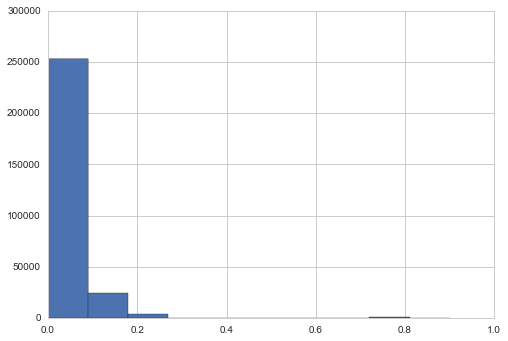

In [4]:
# Detect data stored in knot or m/s
df['decimal'] = df.speed % 1 
df.decimal.hist()
knot_unit = True if len(df.query('decimal >= 0.2'))/len(df) > 0.3 else False

print knot_unit

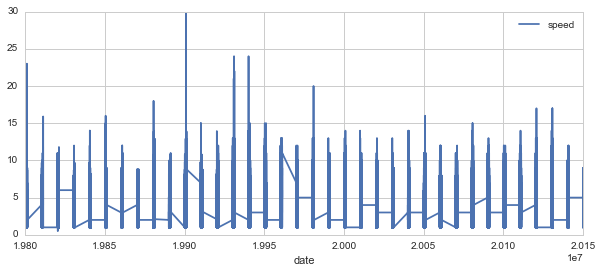

In [5]:
# Using unit in knot instead of m/s
# need more elaboration, some is not near an integer
if knot_unit:
    df.rename(columns={'speed':'speed_mps'}, inplace=True)
    df['speed']=df['speed_mps']
    df['speed']=df['speed_mps']*1.943845
    df['speed']=df['speed'].apply(lambda x: int(round(x)))

df['speed'].plot(legend=True,figsize=(10,4), grid=True)

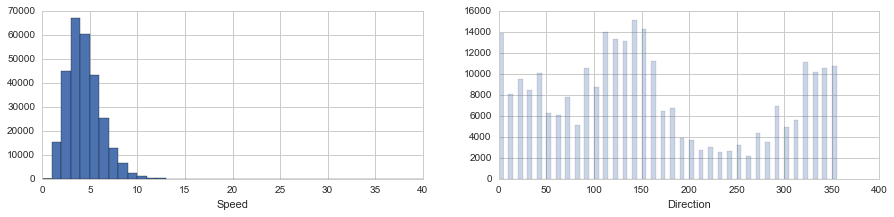

In [6]:
# Notice the gap of the distributions, so futher process needed, as below
plot_speed_and_angle_distribution(df)

## 1.3 Data Wrangling

### 1.3.1 Artefacts handling

In [7]:
## Weird sampling direction, should be deleted
display(df.query('dir % 10 >= 0.1'))
df = df.query('dir % 10 <= 0.1')

,date,HrMn,type,dir,speed,decimal
date,,,,,,
19940128,19940128,0,FM-15,331,3.0,0.0
19940718,19940718,1000,FM-15,113,5.0,0.0
19940805,19940805,1100,FM-15,115,9.0,0.0
19940810,19940810,500,FM-15,131,10.0,0.0
19940903,19940903,2100,FM-15,119,5.0,0.0
19941203,19941203,1400,FM-15,134,3.0,0.0
19950403,19950403,1300,FM-15,113,3.0,0.0
19980603,19980603,1100,FM-15,31,10.0,0.0
19980909,19980909,1200,FM-15,91,20.0,0.0


,date,HrMn,type,dir,speed,decimal,incre,incre_reverse
date,,,,,,,,
19900917,19900917,0,SY-MT,320,30.0,0.0,27.9,24.9
19931012,19931012,2300,FM-16,130,24.0,0.0,22.0,20.0
19940127,19940127,2300,FM-16,280,24.0,0.0,21.0,20.0
19801008,19801008,2100,FM-12,90,23.0,0.0,21.0,19.0
19931221,19931221,2200,FM-15,340,22.0,0.0,19.0,20.0
19800714,19800714,900,FM-12,170,22.0,0.0,20.0,20.0
19930802,19930802,1400,FM-15,310,21.0,0.0,17.0,19.0
19880507,19880507,25,FM-15,280,18.0,0.0,11.0,8.2
20130801,20130801,730,FM-15,280,17.0,0.0,12.0,7.0


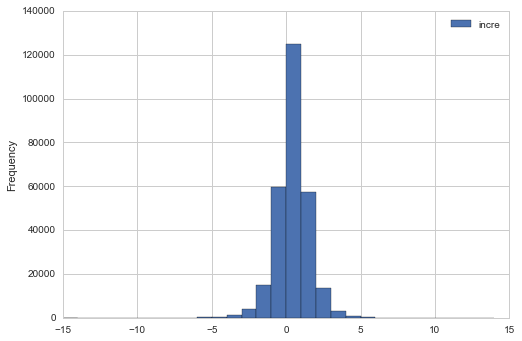

In [8]:
df['incre'] = df.speed.diff(1)
df['incre'].fillna(0, inplace=True)
df['incre_reverse'] = df.speed.diff(-1)
df['incre_reverse'].fillna(0, inplace=True)

display(df.sort_values(by='speed',ascending=False).head(10))
df['incre'].plot(kind='hist', bins=arange(-15, 15), legend=True)

In [9]:
incre_threshold = 20 if knot_unit else 10
df = df.query('(incre < @incre_threshold )&(incre_reverse < @incre_threshold )')

After Simple Aretefacts Handling

In [10]:
# Check the max speed
df.sort_values(by='speed',ascending=False).head(10)

,date,HrMn,type,dir,speed,decimal,incre,incre_reverse
date,,,,,,,,
20120808,20120808,530,FM-15,90,17.0,0.0,2.0,4.0
20050911,20050911,1700,FM-15,90,16.0,0.0,4.0,4.0
19811219,19811219,500,SY-MT,310,15.9,0.9,7.9,7.9
19811219,19811219,700,FM-15,310,15.9,0.9,7.9,3.1
19950309,19950309,1500,FM-15,340,15.0,0.0,4.0,3.0
19941020,19941020,800,FM-15,310,15.0,0.0,6.0,8.0
20120808,20120808,230,FM-15,80,15.0,0.0,1.0,2.0
19951107,19951107,400,FM-15,340,15.0,0.0,5.0,2.0
20120808,20120808,330,FM-15,80,15.0,0.0,2.0,0.0


### 1.3.2 Sampling Type Selection

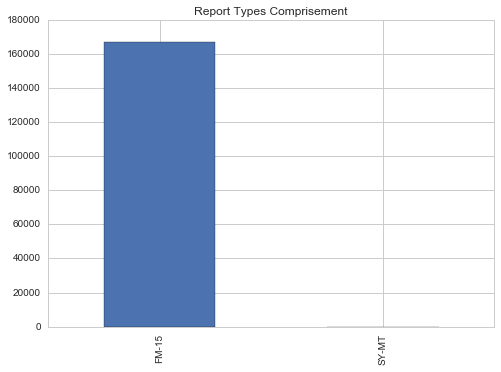

In [11]:
df.query("date >= 20000000 ")['type'].value_counts().plot(
    kind = 'bar', title = 'Report Types Comprisement')

report_type_most_used = df.query("date >= 20000000 ")['type'].value_counts().argmax()
df = df.query("type==@report_type_most_used")

### 1.3.3 Sampling Time Selection

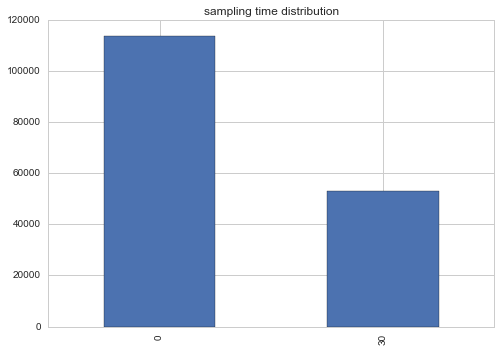

In [12]:
df['sample_time'] = df.HrMn % 100 
df.query("date >= 20000000 ")['sample_time'].value_counts().plot(
    kind = 'bar', title = 'sampling time distribution')

sampling_time_most_used = df.query("date >= 20000000 ")['sample_time'].value_counts().argmax()
df = df.query("sample_time==@sampling_time_most_used")
df.drop(['sample_time'], 1,inplace=True)

In [13]:
df['HrMn'].value_counts().sort_index()

0       7027
100     8319
200     8613
300     7538
400     8951
500     8956
600     7690
700     9245
800     9307
900     7970
1000    8956
1100    8633
1200    7622
1300    8263
1400    7912
1500    6972
1600    7328
1700    7150
1800    6498
1900    6973
2000    6956
2100    6562
2200    7283
2300    7508
Name: HrMn, dtype: int64

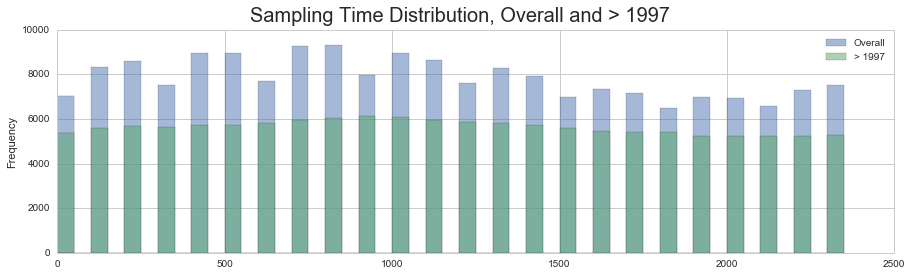

In [14]:
MID_YEAR = int(((min(df.date)+max(df.date))/2 )/10000)
# Ensure data sampled equally
bins=arange(min(df.HrMn), max(df.HrMn) + 100, 50)

df['HrMn'].plot(
    kind='hist', alpha=0.5,figsize=(15, 4),bins=bins, label='Overall')

df.query('date > @MID_YEAR * 10000')['HrMn'].plot(
    kind='hist', alpha=0.5,figsize=(15, 4),bins=bins, label='> %s' %  MID_YEAR )

plt.suptitle('Sampling Time Distribution, Overall and > %s ' %  MID_YEAR, fontsize = 20)
plt.legend()

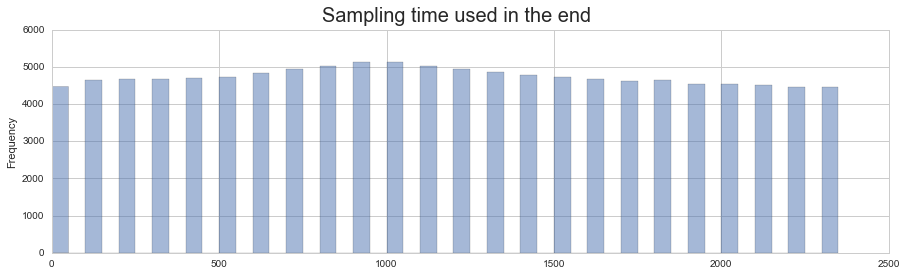

In [15]:
# We're gonna use the most frequent report type, here is its distirbution
df.query('date >= 20000000')['HrMn'].plot(
    kind='hist', alpha=0.5, figsize=(15, 4), bins=bins)

plt.suptitle('Sampling time used in the end', fontsize = 20)

## 1.3.3 Time Shift Comparison

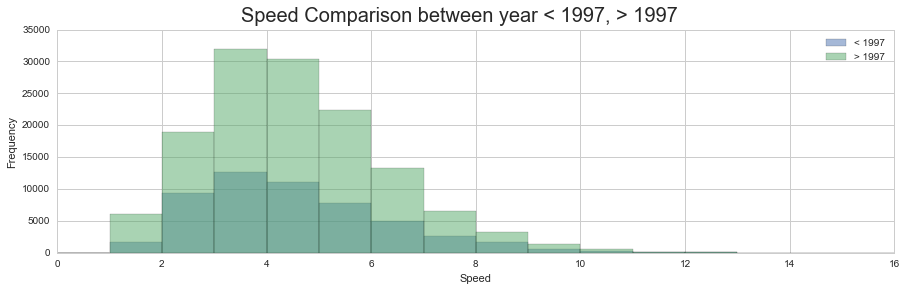

In [16]:
# Comparison between mid_year, looking for: 
# 1. Odd Even Bias
# 2. Time Shift of Wind Speed Distribution
bins = arange(0, max(df.speed) + 1)
df[df['date'] < MID_YEAR * 10000]['speed'].plot(
    kind='hist', alpha=0.5,figsize=(15, 4),bins=bins, label='< %s' % MID_YEAR)

df[df['date'] > MID_YEAR * 10000]['speed'].plot(
    kind='hist', alpha=0.5,figsize=(15, 4),bins=bins, label='> %s' % MID_YEAR)

plt.xlabel("Speed")
plt.suptitle('Speed Comparison between year < %s, > %s ' % (MID_YEAR, MID_YEAR), fontsize = 20)
plt.legend()

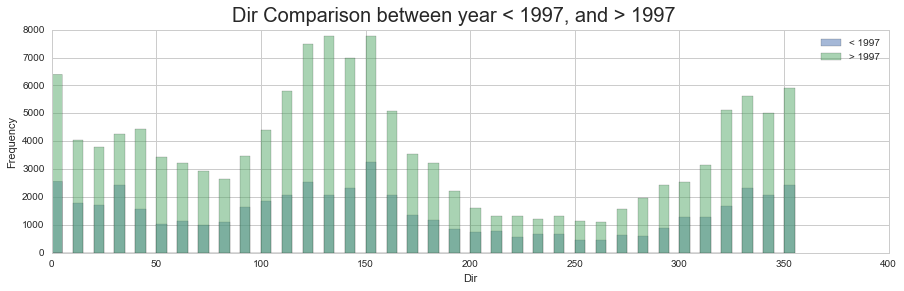

In [17]:
bins=arange(min(df.dir), max(df.dir) + 10, 5)
df[df['date'] < MID_YEAR * 10000]['dir'].plot(
    kind='hist', alpha=0.5,figsize=(15, 4),bins=bins, label='< %s' % MID_YEAR)

df[df['date'] > MID_YEAR * 10000]['dir'].plot(
    kind='hist', alpha=0.5,figsize=(15, 4),bins=bins, label='> %s' % MID_YEAR)

plt.xlabel("Dir")
plt.suptitle('Dir Comparison between year < %s, and > %s ' % (MID_YEAR, MID_YEAR), fontsize = 20)
plt.legend()

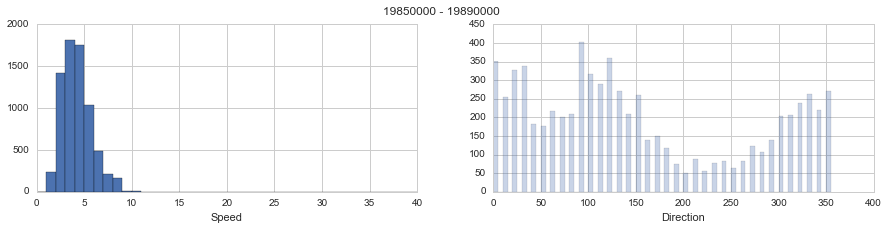

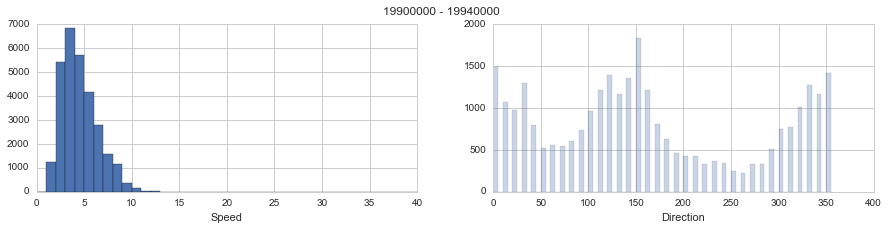

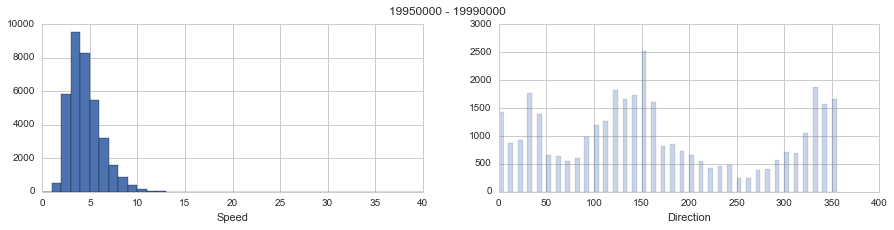

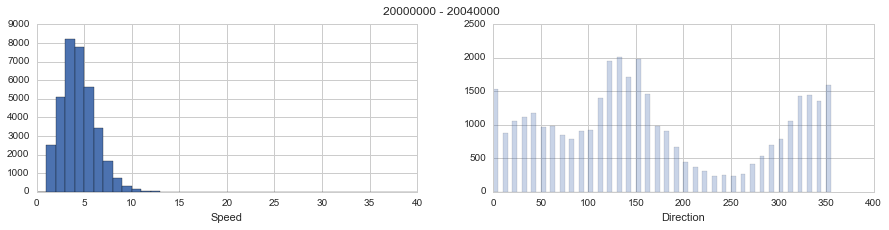

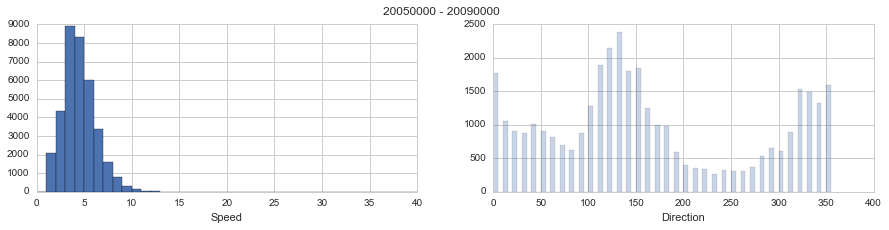

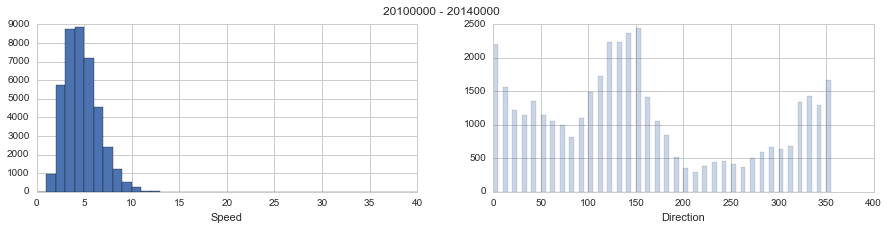

In [18]:
# Inspect the time shift of speed and degree distribution, and odd-even bias
def check_time_shift(df):
    for start_time in xrange(19850000, 20150000, 50000):
        end_time = start_time + 50000 
        sub_df = df.query('(date >= @start_time) & (date < @end_time)')
        if len(sub_df) > 0 :
            title = '%s - %s' %(start_time, end_time-10000)
            plot_speed_and_angle_distribution(sub_df, title)
        
check_time_shift(df)

## 1.4 Re-select data, data conversion, and overview of the clean dataset

In [19]:
## Summery of the data selection
print 'incre_threshold for artefact detect:', incre_threshold
print 'Report type used:', report_type_most_used
print 'Sampling time used:', sampling_time_most_used

df = df.query('(date >= 2000000) & (date < 20150000)')
df.describe()

incre_threshold for artefact detect: 10
Report type used: FM-15
Sampling time used: 0


,date,HrMn,dir,speed,decimal,incre,incre_reverse
count,1.868770e+05,186877.000000,186877.000000,186877.000000,186877.000000,186877.000000,186877.000000
mean,2.001989e+07,1106.171439,161.113085,4.060347,0.013718,0.045560,0.045442
std,7.693044e+04,679.721408,108.352681,1.797560,0.051843,1.097728,1.091068
min,1.980010e+07,0.000000,0.000000,1.000000,0.000000,-24.900000,-27.900000
25%,1.996022e+07,500.000000,80.000000,3.000000,0.000000,-1.000000,-1.000000
50%,2.002082e+07,1100.000000,140.000000,4.000000,0.000000,0.000000,0.000000
75%,2.009023e+07,1700.000000,260.000000,5.000000,0.000000,1.000000,1.000000
max,2.014123e+07,2300.000000,350.000000,16.000000,0.900000,9.000000,9.000000


### 1.4.1 Overview

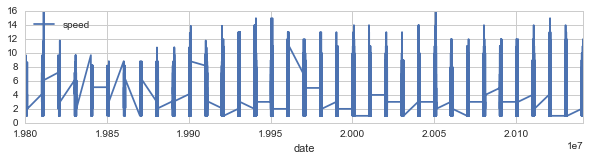

In [20]:
df['speed'].plot(legend=True,figsize=(10,2), grid=True)

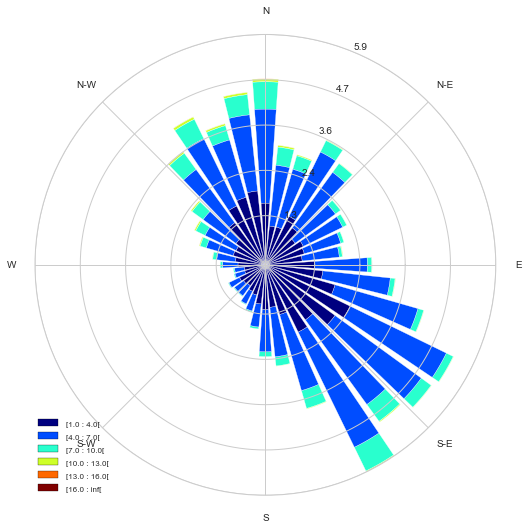

In [21]:
df.dir_windrose = df.dir
# 90 degree is in east
ax = WindroseAxes.from_ax()
ax.bar(df.dir_windrose, df.speed, normed=True, opening=0.8, edgecolor='white', nsector=36)
ax.set_legend()

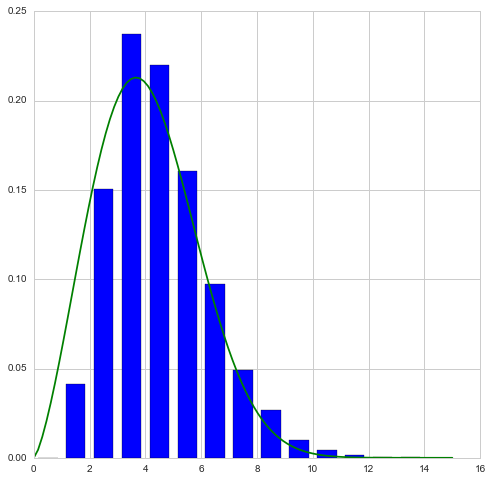

In [22]:
ax, _params = WindAxes.from_ax().pdf(df.speed, 
                                     bins=arange(0, max(df.speed)))
weibull_params = sp.stats.exponweib.fit(df.speed, floc=0, f0=1)

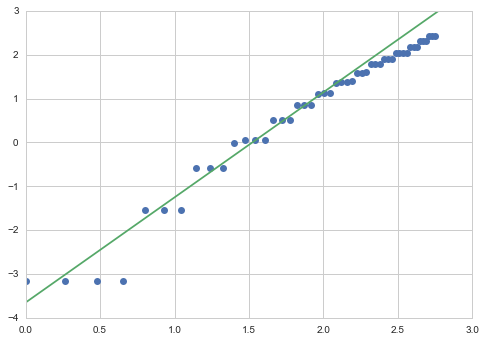

In [23]:
sample = df.speed
ecdf = sm.distributions.ECDF(sample)

x = linspace(min(sample), max(sample))
y = ecdf(x)
plt.plot(log(x), log(-log(1-y)),'o')

w_scale, c_shape = weibull_params[1], weibull_params[3]
qz=exp(-(x/c_shape)**w_scale)
plt.plot(log(x), log(-log(qz)),'-')

### 1.4.2 Direction Conversion, from windrose to polar system
e.g. 0 degree = north, clockwise => 90 degree = north, counterclockwise

In [24]:
df['dir'] = df['dir'].apply(lambda x: (90 - x)%360)
df['dir'].value_counts().sort_index()

0       5086
10      3716
20      3898
30      4321
40      4437
50      5987
60      6622
70      5461
80      5732
90      8867
100     8268
110     7001
120     7849
130     6674
140     4387
150     3762
160     3282
170     2546
180     2158
190     1539
200     1560
210     1971
220     1866
230     1864
240     2113
250     2348
260     3075
270     4377
280     4857
290     7144
300    10980
310     9262
320     9785
330     9979
340     7866
350     6237
Name: dir, dtype: int64

In [25]:
effective_coloumn = df['dir'].value_counts()[df['dir'].value_counts() > 30].sort_index()

if len(effective_coloumn) == 16:
    # For some dataset, the angle is not evenly distributed, so there is a need to redistribute
    original_angle = list(effective_coloumn.sort_index().index)
    redistributed_angle = linspace(0,360,num=17)[:-1]
    df['dir'].replace(to_replace=original_angle, value=redistributed_angle, inplace=True)
    display(df['dir'].value_counts().sort_index())

In [26]:
df.describe()

,date,HrMn,dir,speed,decimal,incre,incre_reverse
count,1.868770e+05,186877.000000,186877.000000,186877.000000,186877.000000,186877.000000,186877.000000
mean,2.001989e+07,1106.171439,184.616619,4.060347,0.013718,0.045560,0.045442
std,7.693044e+04,679.721408,113.799187,1.797560,0.051843,1.097728,1.091068
min,1.980010e+07,0.000000,0.000000,1.000000,0.000000,-24.900000,-27.900000
25%,1.996022e+07,500.000000,90.000000,3.000000,0.000000,-1.000000,-1.000000
50%,2.002082e+07,1100.000000,160.000000,4.000000,0.000000,0.000000,0.000000
75%,2.009023e+07,1700.000000,300.000000,5.000000,0.000000,1.000000,1.000000
max,2.014123e+07,2300.000000,350.000000,16.000000,0.900000,9.000000,9.000000


### 1.4.3 Re-distribute Direction, within each sector (optional)
e.g. Dir 50 -> -45 ~ 55, to make KDE result better

In [27]:
SECTOR_LENGTH = 360/len(effective_coloumn)
print len(effective_coloumn), SECTOR_LENGTH

def randomize_angle(df, sector_length = 10):
    df['dir_ran'] = df['dir'].apply(lambda x: (x + np.random.uniform(-sector_length/2,sector_length/2))% 360)

    bins=arange(0, 360+10, 5)
    df['dir'].hist(bins=bins, alpha=0.5,figsize=(15, 6))
    bins=arange(0, 360+10, 1)
    df['dir_ran'].hist(bins=bins, alpha=0.5,figsize=(15, 6))
    
    df['dir']=df['dir_ran']
    df.drop(['dir_ran'], 1,inplace=True)
    return df

36 10.0


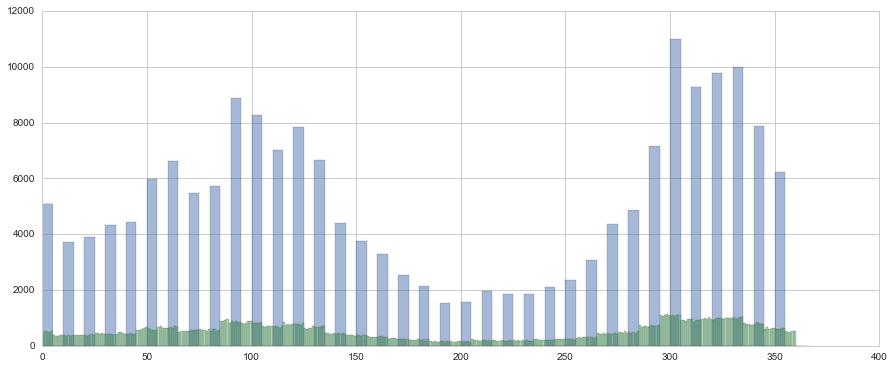

In [28]:
# Randomize the angle degree, to form a better KDE estimation
df['dir_int'] = df['dir']
df = randomize_angle(df, SECTOR_LENGTH)

In [29]:
def randomize_speed(df):
    # Round down speed, need more caution
    df['speed_ran'] = df['speed'].apply(lambda x: (x + np.random.uniform(-1,0)) if x > 0 else x)
    
    max_speed = df.speed.max()
    df['speed'].hist(bins=arange(0, max_speed), 
                     alpha=0.5,figsize=(15, 6))
    df['speed_ran'].hist(bins=arange(0, max_speed, 0.5), 
                         alpha=0.5,figsize=(15, 6))
    
    df['speed']=df['speed_ran']
    df.drop(['speed_ran'], 1,inplace=True)
    return df

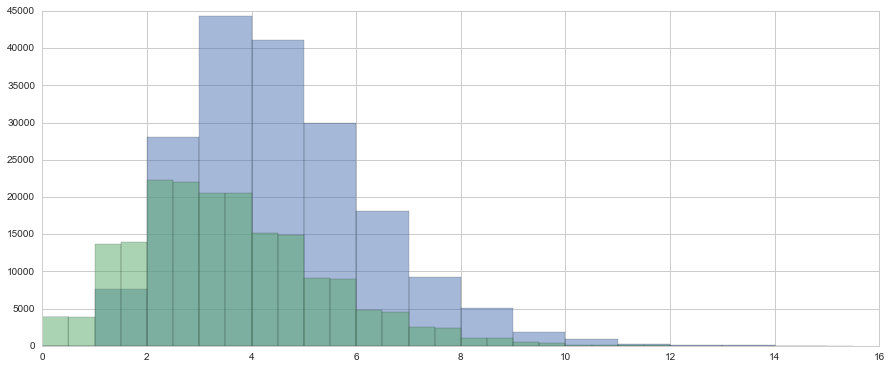

In [30]:
# Each original cell is split between the value, # so the peak is shift left
# e.g. 2 -> (1.5,2), (2,2.5); or 3 -> (2,3)
df['speed_int'] = df['speed']
df = randomize_speed(df)

### 1.4.4 Generate (x,y) from (speed,dir)

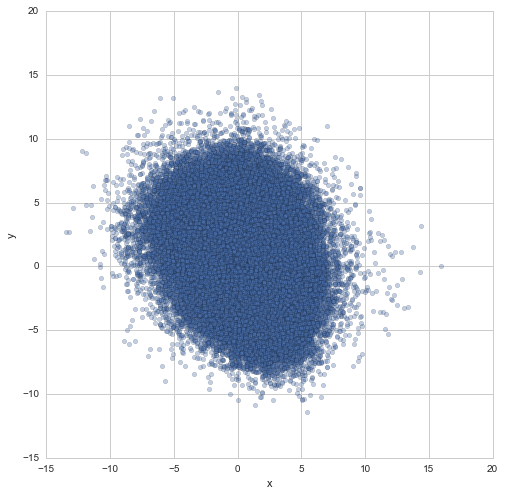

In [31]:
df['x'] = df['speed'] * cos(df['dir'] * pi / 180.0)
df['y'] = df['speed'] * sin(df['dir'] * pi / 180.0)
fig, ax = plt.subplots(figsize=(8, 8), dpi=80)
ax.set_aspect('equal')
df.plot(kind='scatter', x='x', y='y', alpha=0.35, ax=ax)

# 2. Create input data, i.e. speed_set

In [32]:
# speed_set = array(zip(-df.x, -df.y)) # Adjust the direction to match for Cook's paper
df_all_years = df
df = df.query('(date >= 20100000) & (date < 20150000)')
speed_set = array(zip(df.x, df.y))
speed_angle_set = array(zip(df.speed, df.dir))
max_speed = df.speed.max()
NUMBER_OF_GAUSSIAN = 3

In [33]:
FITTING_RANGE = []
if knot_unit == True:
    fitting_axis_range = arange(-20, 21, 1)
    PLOT_AXIS_RANGE = arange(-25, 25, 1)
else:
    fitting_axis_range = arange(-10, 11, 1)
    PLOT_AXIS_RANGE = arange(-10, 11, 1)
    
for i in fitting_axis_range:
    for j in fitting_axis_range:
        FITTING_RANGE.append([i,j])

# 3. Kernel Density Estimation

In [34]:
sample = speed_set

In [35]:
# # The bandwidth value would be too radical, so we forsake this approach
# from sklearn.grid_search import GridSearchCV
# grid = GridSearchCV(neighbors.KernelDensity(),
#                     {'bandwidth': linspace(0.5, 1.0, 7)},
#                     n_jobs=-1, cv=4) 
# grid.fit(sample)
# bandwidth = grid.best_params_['bandwidth']
# kde = grid.best_estimator_

In [36]:
bandwidth = 0.9 if knot_unit else 0.4
kde = neighbors.KernelDensity(bandwidth=bandwidth).fit(sample)

points = FITTING_RANGE
# very slow if the dataset is too large, e.g. 100,000
# kde returns log prob, need to convert it
kde_result = exp(kde.score_samples(points))
print bandwidth, len(kde_result)
print kde_result[:5]

0.4 441
[  1.09532120e-31   2.82731973e-30   1.40886001e-31   2.54483217e-34
   8.73421732e-29]


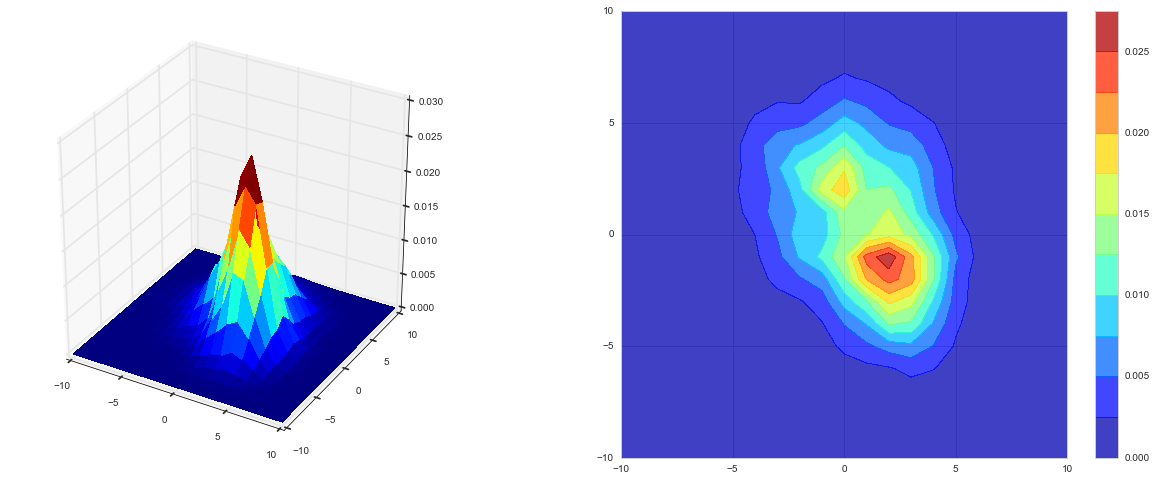

In [37]:
# Plot jPDF
X = Y = PLOT_AXIS_RANGE
# Can't work if pass as generate_Z_from_X_Y(X,Y, exp(kde.score_samples())), need to use lambda
# see http://stackoverflow.com/questions/21035437/passing-a-function-as-an-argument-in-python
kde_Z = generate_Z_from_X_Y(X,Y, lambda coords: exp(kde.score_samples(coords)))

fig = plt.figure(figsize=(22,8))
ax1 = fig.add_subplot(1,2,1, projection = '3d')
plot_3d_prob_density(X,Y,kde_Z,ax1)
ax2 = fig.add_subplot(1,2,2)
plot_2d_prob_density(X,Y,kde_Z,ax2)

In [38]:
kde_cdf = cdf_from_pdf(kde_result)

# 4. GMM Estimation, using EM algo

In [39]:
sample= speed_set
clf = mixture.GMM(n_components=NUMBER_OF_GAUSSIAN, covariance_type='full')
clf.fit(sample)

clf.converged_

True

In [40]:
gmm_em_result = read_gmm_em_result(clf, print_result = False)
pretty_print_gmm(gmm_em_result)  

,weight,mean_x,mean_y,sig_x,sig_y,corr
0,0.410134,2.085929,-1.797866,1.656317,2.212328,-0.233074
1,0.301838,1.426214,2.556663,2.179074,2.775354,-0.210925
2,0.288029,-1.392797,1.191033,2.391959,2.767881,-0.248643


GMM Plot Result
0.410133910221 [[ 2.08592871 -1.79786627]] [ 1.56381922  2.27865134] -160.773481548
0.301837567602 [[ 1.42621383  2.55666302]] [ 2.06731683  2.85957233] -159.593289003
0.288028522177 [[-1.39279709  1.19103323]] [ 2.18647733  2.93290782] -150.252238342


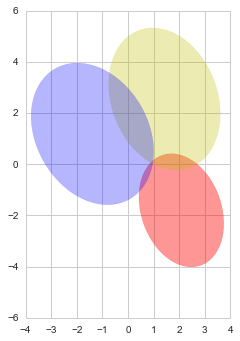

In [41]:
plot_gmm_ellipses(gmm_em_result)

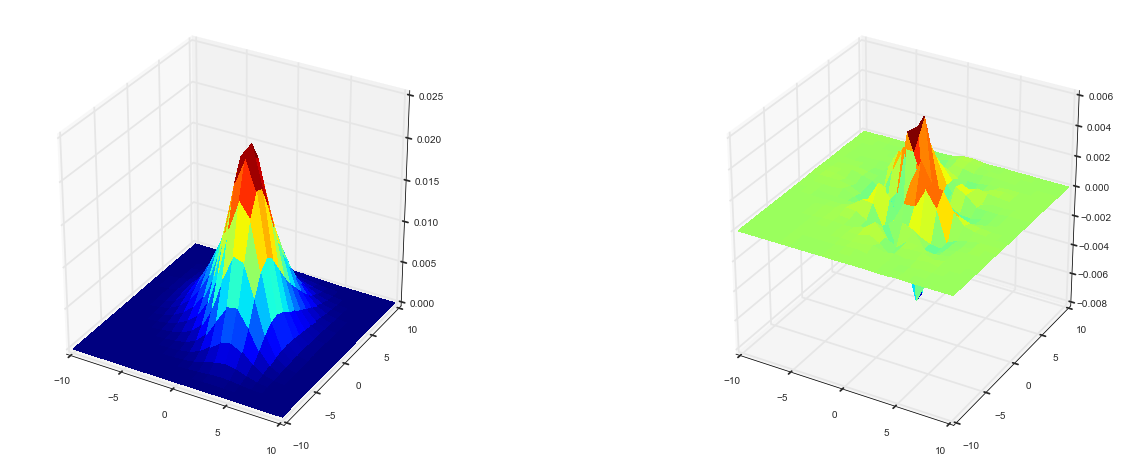

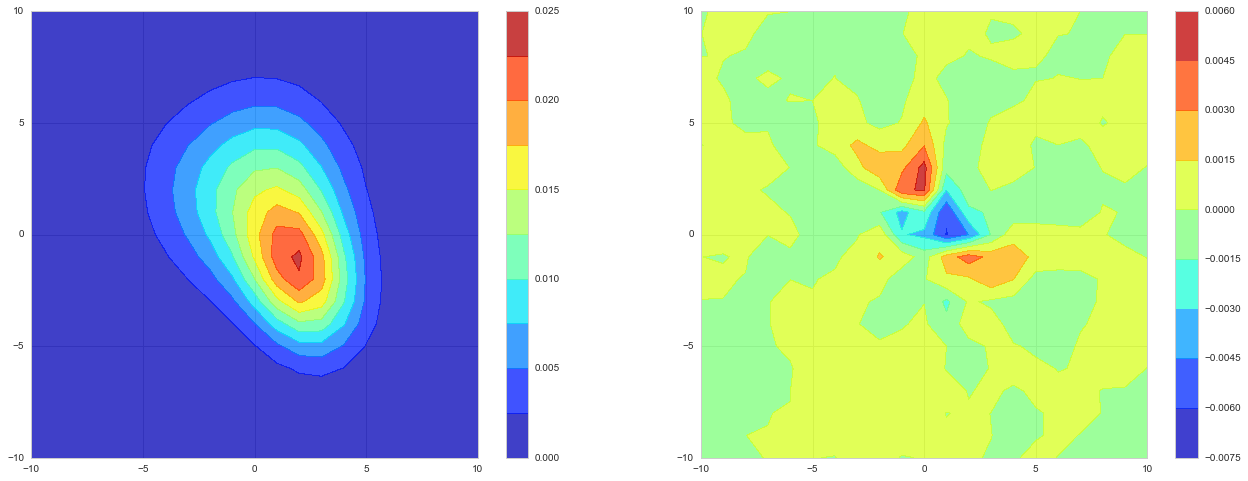

In [42]:
X = Y = PLOT_AXIS_RANGE
pdf_Z = generate_Z_from_X_Y(X,Y, lambda coords: exp(clf.score_samples(coords)[0]))

def residule_between_kde_and_gmm(points):
    kde_vals = exp(kde.score_samples(points))
    gmm_vals = exp(clf.score_samples(points)[0])
    return kde_vals - gmm_vals 

residual_Z = generate_Z_from_X_Y(X,Y, residule_between_kde_and_gmm)

fig = plt.figure(figsize=(22,8))
ax1 = fig.add_subplot(1,2,1, projection = '3d')
plot_3d_prob_density(X,Y,pdf_Z,ax1)
ax2 = fig.add_subplot(1,2,2,projection = '3d')
plot_3d_prob_density(X,Y,residual_Z,ax2)

fig = plt.figure(figsize=(22,8))
ax1 = fig.add_subplot(1,2,1)
plot_2d_prob_density(X,Y,pdf_Z,ax1)
ax2 = fig.add_subplot(1,2,2)
plot_2d_prob_density(X,Y,residual_Z,ax2)

## GMM, EM VS. KDE

In [43]:
points = FITTING_RANGE
gmm_pdf_result = exp(clf.score_samples(points)[0])
# put into Pandas to make it looks better
pd.DataFrame([goodness_of_fit_summary(gmm_pdf_result, kde_result, count = len(df))])

,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,0.041535,0.021485,7.259623e-07,0.031698,0.375271,0.963355


# 5. Least Square Prob Estimation

In [44]:
sample = speed_set
points = FITTING_RANGE

In [45]:
def GMM_fit_score(gmm, kde_result, method = 'square_error'): 
    # 1. Create the GMM PDF
    if not isinstance(gmm[0], np.ndarray):
        gmm = group_gmm_param_from_gmm_param_array(gmm, sort_group = False)
    mixed_model_pdf = generate_gmm_pdf_from_grouped_gmm_param(gmm)
    # 2. Fit the model using different metrics
    gmm_pdf_result = mixed_model_pdf(points)
    if method == 'square_error':
        # 2.1 Square error
        error_array = power(gmm_pdf_result - kde_result,2)
        result = mse_log = log(np.average(error_array))
    elif method == 'chi_square':
        # 2.2 Chi square
        error_array = power(gmm_pdf_result - kde_result,2)
        # unable to * count = 43412, use normalized chi square
        result = chi_square_stat = log(sum(error_array/gmm_pdf_result))
    elif method == 'K_S':
        # 2.3 K-S statistc
        gmm_cdf = cdf_from_pdf(gmm_pdf_result)
        diff = abs(gmm_cdf - kde_cdf)
        result = KS_stat = log(np.amax(diff))
    return result

# from GMM,EM 
# GMM format: weight, meanx, meany, sigx, sigy, rho
x0 = gmm_em_result

cons = [
    # sum of every 6th element, which is the fraction of each gaussian
    {'type': 'eq', 'fun': lambda x: sum(x[::6]) - 1},
    # limit the width/height ratio of elliplse, optional
#     {'type': 'ineq', 'fun': lambda x: width_height_ratios_set(x) - 1/3},
#     {'type': 'ineq', 'fun': lambda x: 3 - width_height_ratios_set(x)},
]

bonds = [(0., 0.99),(-30, 30),(-30, 30),(0., 30),(0., 30),(-0.99, 0.99)]*int(len(x0)/6)
FIT_METHOD = 'chi_square'
result = sp.optimize.minimize(
    lambda x0: GMM_fit_score(x0, kde_result, FIT_METHOD),
    x0,
    bounds = bonds,
    constraints=cons,
    tol = 0.000000000001,
    options = {"maxiter": 500})
result

     fun: -3.6233429547918523
     jac: array([ -1.16107842e+00,   0.00000000e+00,  -8.94069672e-08,
        -1.49011612e-07,   4.47034836e-07,  -7.45058060e-07,
        -1.16107875e+00,  -8.94069672e-08,   1.78813934e-07,
        -5.96046448e-08,  -3.57627869e-07,  -5.96046448e-07,
        -1.16107643e+00,   2.98023224e-08,   2.38418579e-07,
        -1.78813934e-07,  -3.27825546e-07,   5.36441803e-07,
         0.00000000e+00])
 message: 'Optimization terminated successfully.'
    nfev: 936
     nit: 46
    njev: 46
  status: 0
 success: True
       x: array([ 0.35894273,  2.31605635, -1.95816266,  1.52745218,  1.9631696 ,
       -0.0800336 ,  0.15544568, -0.34567426, -0.30287604,  3.24044626,
        3.3528401 , -0.41560571,  0.48561159,  0.1928402 ,  2.34212406,
        2.45146924,  2.61742881,  0.01495904])

## LRMSE VS. KDE

In [46]:
kde_result[:5]

array([  1.09532120e-31,   2.82731973e-30,   1.40886001e-31,
         2.54483217e-34,   8.73421732e-29])

In [47]:
gmm = group_gmm_param_from_gmm_param_array(result.x, sort_group = True)
mixed_model_pdf = generate_gmm_pdf_from_grouped_gmm_param(gmm)
gmm_pdf_result = mixed_model_pdf(points)

pretty_print_gmm(gmm)

,weight,mean_x,mean_y,sig_x,sig_y,corr
0,0.485612,0.192840,2.342124,2.451469,2.617429,0.014959
1,0.358943,2.316056,-1.958163,1.527452,1.963170,-0.080034
2,0.155446,-0.345674,-0.302876,3.240446,3.352840,-0.415606


GMM Plot Result
0.485611588107 [[ 0.1928402   2.34212406]] [ 2.44926283  2.61949358] 173.572559603
0.358942729326 [[ 2.31605635 -1.95816266]] [ 1.51530179  1.9725632 ] -171.242471958
0.155445682566 [[-0.34567426 -0.30287604]] [ 2.51801655  3.92448995] -137.345503112


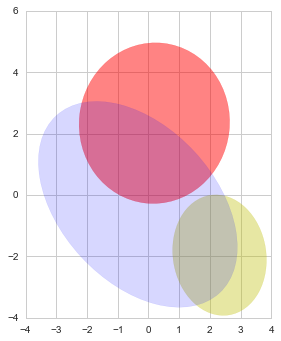

In [48]:
plot_gmm_ellipses(gmm)

## Goodness-of-fit indicators

In [49]:
pd.DataFrame(
    [goodness_of_fit_summary(gmm_pdf_result, kde_result, count = len(df))])

,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,0.026693,0.015815,4.944900e-07,0.026161,0.309718,0.97504


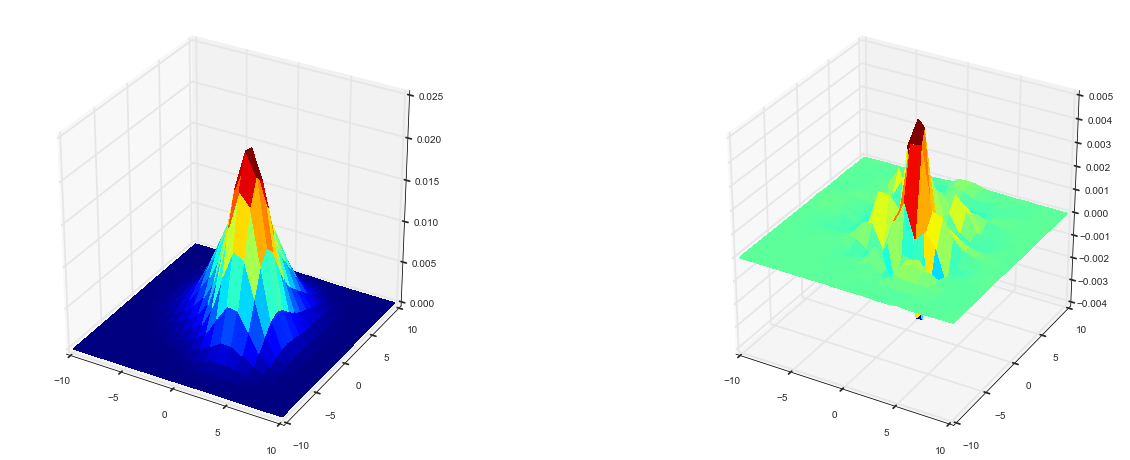

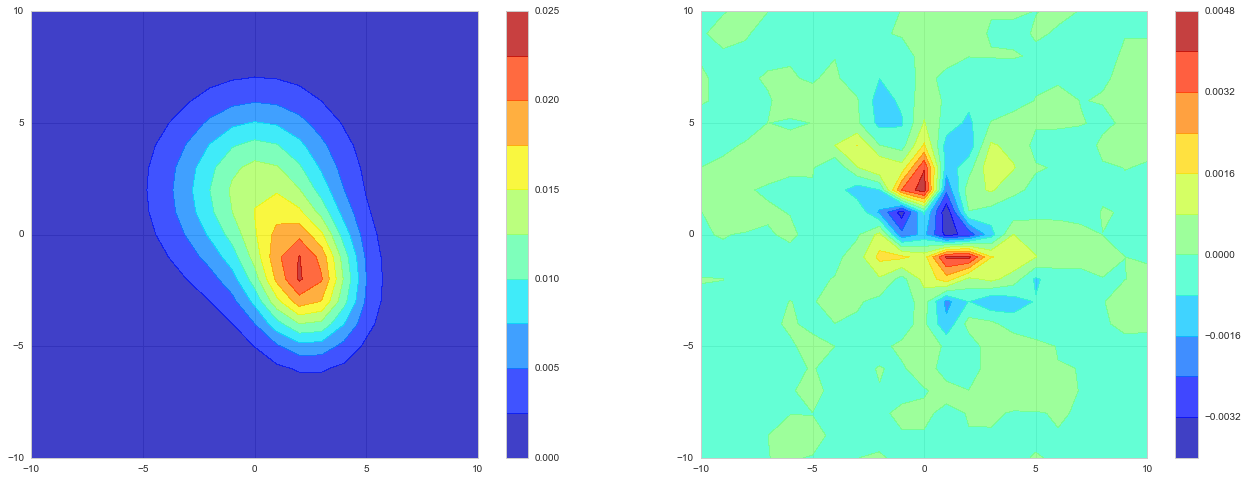

In [50]:
X = Y = PLOT_AXIS_RANGE
pdf_Z = generate_Z_from_X_Y(X,Y, mixed_model_pdf)# passing a function as an argument

def residule_between_kde_and_gmm(points):
    kde_vals = exp(kde.score_samples(points))
    gmm_vals = mixed_model_pdf(points)
    return kde_vals - gmm_vals 

residual_Z = generate_Z_from_X_Y(X,Y, residule_between_kde_and_gmm)

fig = plt.figure(figsize=(22,8))
ax1 = fig.add_subplot(1,2,1, projection = '3d')
plot_3d_prob_density(X,Y,pdf_Z,ax1)
ax2 = fig.add_subplot(1,2,2,projection = '3d')
plot_3d_prob_density(X,Y,residual_Z,ax2)

fig = plt.figure(figsize=(22,8))
ax1 = fig.add_subplot(1,2,1)
plot_2d_prob_density(X,Y,pdf_Z,ax1)
ax2 = fig.add_subplot(1,2,2)
plot_2d_prob_density(X,Y,residual_Z,ax2)

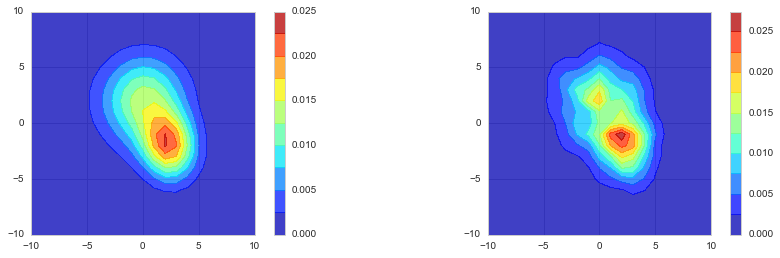

In [51]:
fig = plt.figure(figsize=(15,4))
ax1 = fig.add_subplot(1,2,1)
plot_2d_prob_density(X,Y,pdf_Z,ax1)
ax2 = fig.add_subplot(1,2,2)
plot_2d_prob_density(X,Y,kde_Z,ax2)

In [52]:
def f(V,theta):
    return (mixed_model_pdf([[V*cos(theta),V*sin(theta)]]))*V

x_vals_OEN3_LMSE  = arange(0, max_speed)
y_vals_OEN3_LMSE =[integrate.nquad(f, [[0, x_val],[0, 2*pi]]) for x_val in x_vals_OEN3_LMSE ]

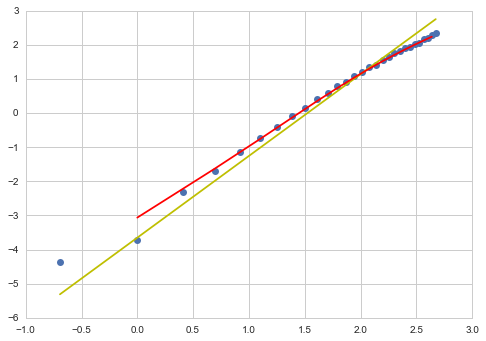

In [53]:
x = arange(0, max_speed, 0.5)

# 1. Plot v-p points, empirical distribution
ecdf = sm.distributions.ECDF(df.speed)
y = ecdf(x)
plt.plot(log(x), log(-log(1-y)),'o')

# 2. Weibull distribution
w_scale, c_shape = weibull_params[1], weibull_params[3]
qz=exp(-(x/c_shape)**w_scale)
plt.plot(log(x), log(-log(qz)),'-', color = 'y')

# 3. OEN3 distribution, LMSE
x, y_ = x_vals_OEN3_LMSE, y_vals_OEN3_LMSE
y = array(zip(*y_)[0])
plt.plot(log(x), log(-log(1-y)),'-', color = 'r')

plt.show()

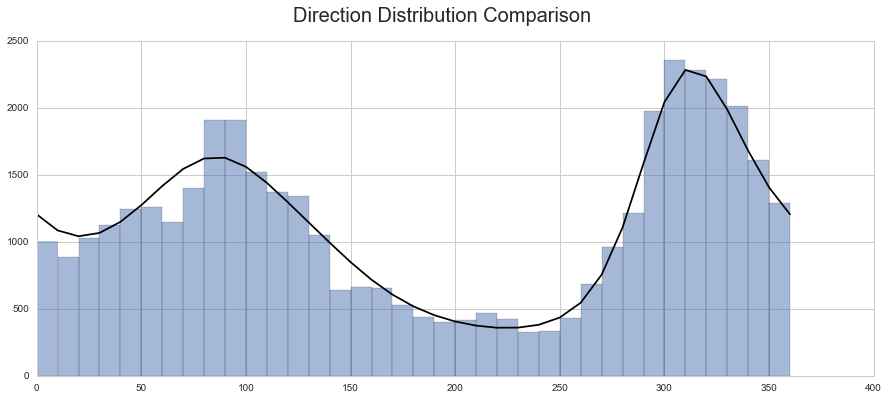

In [54]:
# Calculate Angle Distribution
x_vals = linspace(0,2*pi, num=36+1)
y_vals_ =[integrate.nquad(f, [[0, inf],[x_val-pi/36, x_val+pi/36]]) for x_val in x_vals]

# 1. integrate.nquad returns 2 vaule, result, abserr. Need to abstract the first to plot
# 2. * length of data size, to adjust the plot space
y_vals = array(zip(*y_vals_)[0])*len(df['dir']) 

bins=arange(0, 360 + 1, 10)
df['dir'].hist(bins=bins, alpha=0.5,figsize=(15, 6))

plt.plot(x_vals/pi*180, y_vals,'-', color='black')
plt.suptitle('Direction Distribution Comparison', fontsize = 20)
plt.show()

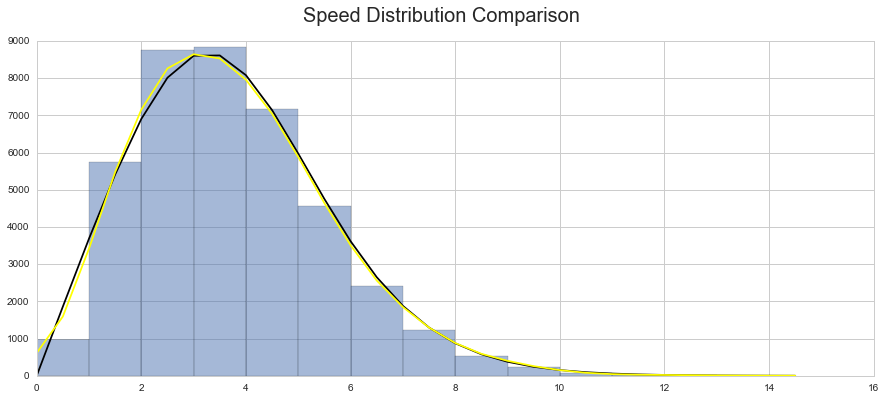

In [55]:
# Calculate Speed Distribution
# 1. GMM Model
x_vals = arange(0, max_speed, 0.5)
y_vals_ =[integrate.nquad(f, [[x_val-0.1, x_val+0.1],[0, 2*pi]]) for x_val in x_vals]
y_vals = array(zip(*y_vals_)[0])*len(df.speed)/0.2
plt.plot(x_vals, y_vals,'-', color='black')

# 2. Observation
df['speed'].hist(bins=arange(0, max_speed), alpha=0.5,figsize=(15, 6))

# 3. 1d KDE
sample = array(df.speed).reshape(-1, 1)
kde_temp = neighbors.KernelDensity(bandwidth=0.5).fit(sample) 
y_vals = [exp(kde_temp.score_samples(x_val))*len(sample) for x_val in x_vals]
plt.plot(x_vals, y_vals,'-', color='yellow')

plt.suptitle('Speed Distribution Comparison', fontsize = 20)
plt.show()

In [56]:
# Calculate Speed Distribution
def model_data_comparison(df, original_incre = 10, incre = 10):
    start, end = -original_incre/2 + incre/2, 360
    max_diff_array = []
    max_speed = df.speed.max()
    
    # Find a max count for plotting histogram
    max_count = max_count_for_histogram(df.speed, 360/incre)
    hist_y_axis = [0, max_speed, 0, max_count]
    
    for angle in arange(start, end, incre):
        angle_radian, incre_radian = radians(angle), radians(incre)  
        start_angle, end_angle = angle-incre/2, angle+incre/2
        
        # Select data from observation
        sub_df, sub_max_speed = select_df_by_angle(df, start_angle, end_angle)
        direction_prob = integrate.nquad(f, [[0, inf],[angle_radian-incre_radian/2, angle_radian+incre_radian/2]])
        
        # 1. Count comparison
        # 1.1. Data Count
        fig = plt.figure(figsize=(22,4))
        ax1 = fig.add_subplot(1,4,1)        
        sub_df['speed'].hist(bins=arange(0, sub_max_speed), alpha=0.5)
        plt.axis(hist_y_axis)
        
        # 1.2. Model Count
        x_vals = arange(0, sub_max_speed, 0.2)
        y_vals_ =[integrate.nquad(f, 
                  [[x_val-0.1, x_val+0.1],[angle_radian-incre_radian/2, angle_radian+incre_radian/2]]) 
                  for x_val in x_vals]
        y_vals = array(zip(*y_vals_)[0])/direction_prob[0] * len(sub_df.speed)/0.2
        plt.plot(x_vals, y_vals,'-', color='black')
    
        plt.suptitle('%s (%s - %s) Degree Speed Distribution Comparison' % (angle, start_angle, end_angle), 
                     fontsize = 15)
        
        # 2. CDF, Weibull plot comparison
        x =arange(0, sub_max_speed, 0.5)
        # 2.1. Data's empirical distribution
        ecdf = sm.distributions.ECDF(sub_df.speed)
        y_cdf = ecdf(x)
        
        # 2.2. Model
        y_ =[integrate.nquad(f, [[0, x_val],[angle_radian-incre_radian/2, angle_radian+incre_radian/2]]) 
             for x_val in x]
        y_gmm = array(zip(*y_)[0])/direction_prob[0]
                
        # 2.3.1. Plot in ordinary axis
        ax3 = fig.add_subplot(1,4,2)
        plt.plot(x, y_cdf,'o')
        plt.plot(x, y_gmm,'-', color = 'r')
        
        # 2.3.2. P-P Plot
        ax2 = fig.add_subplot(1,4,3)
        p_line = linspace(0, 1)
        plt.plot(y_gmm,y_cdf, 'o')
        plt.plot(p_line, p_line,'-')
        
        # 2.3.3. Weibull plot
        ax4 = fig.add_subplot(1,4,4)
        plt.plot(log(x), log(-log(1-y_cdf)),'o')
        plt.plot(log(x), log(-log(1-y_gmm)),'-', color = 'r')
        plt.show()
        
        diff = abs(y_cdf - y_gmm)
        max_diff_array.append([angle, diff.max(), x[diff.argmax()]])
        print diff.max(), x[diff.argmax()], y_gmm[diff.argmax()]
    return max_diff_array

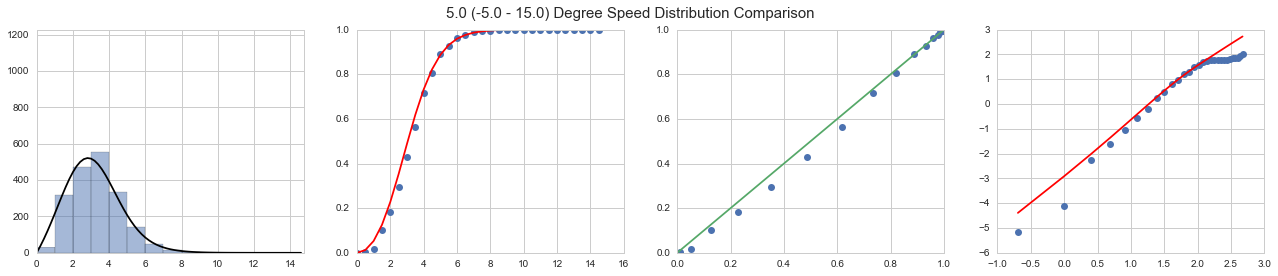

0.0602495515516 3.0 0.488151685857


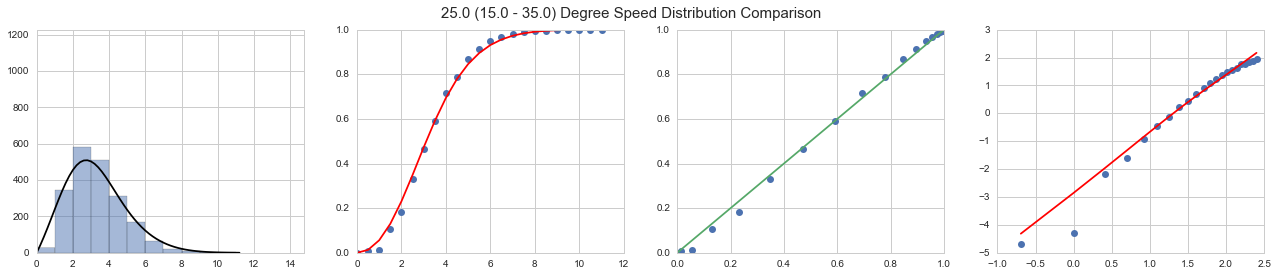

0.047247555225 2.0 0.230394169935


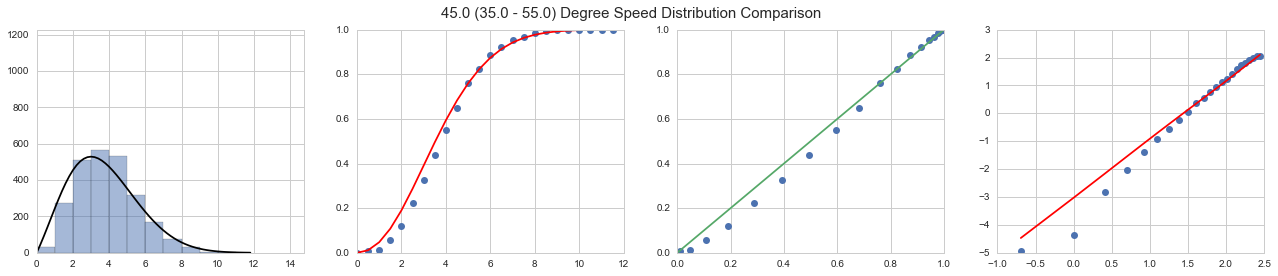

0.067809281507 2.0 0.189974024842


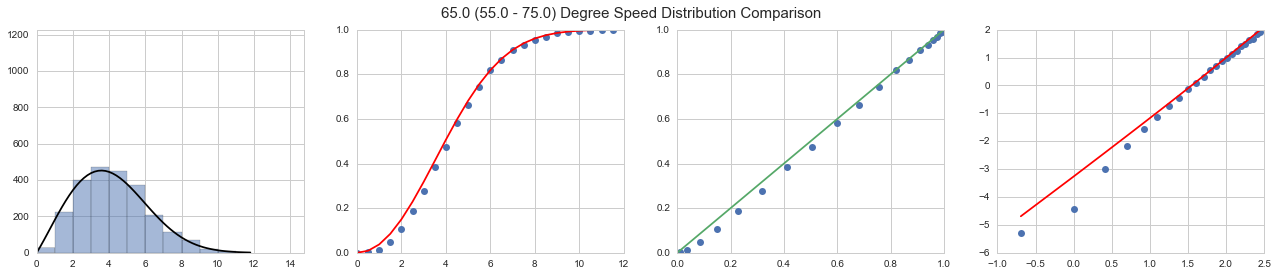

0.0431484963905 2.0 0.149916045781


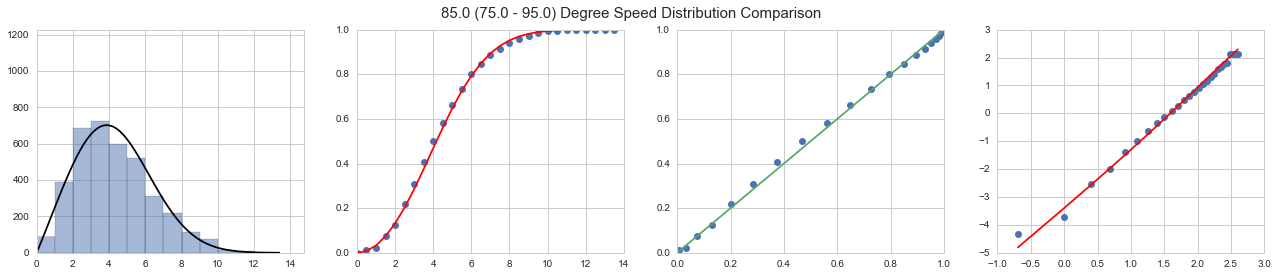

0.0339418732783 4.0 0.468316962757


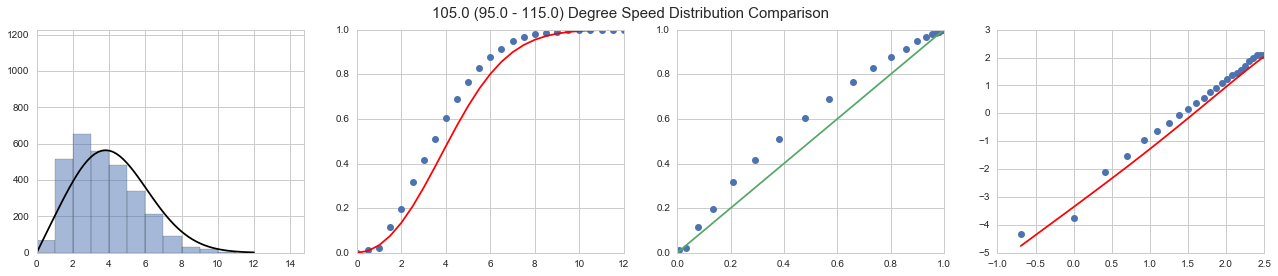

0.126094945632 4.0 0.477931900006


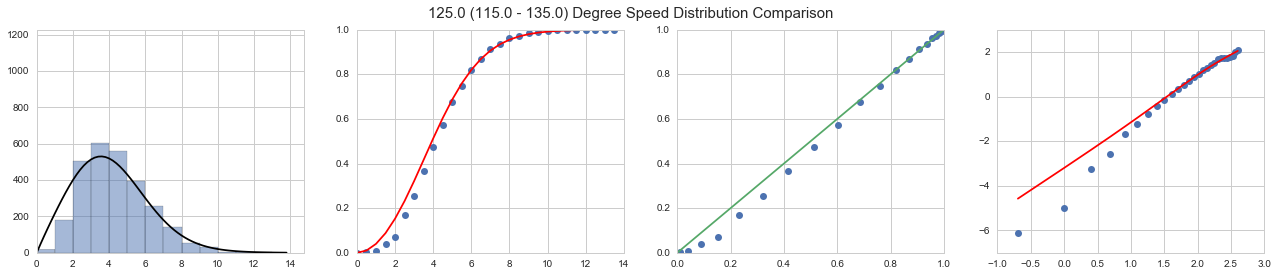

0.0802457646148 2.0 0.153071851571


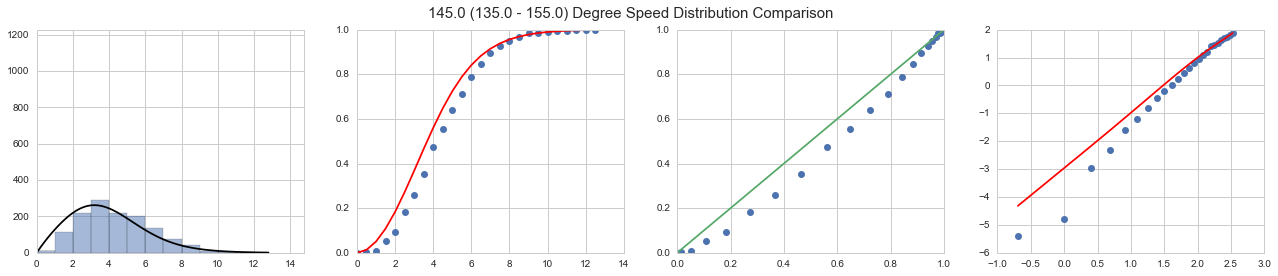

0.110535516077 3.0 0.367272043023


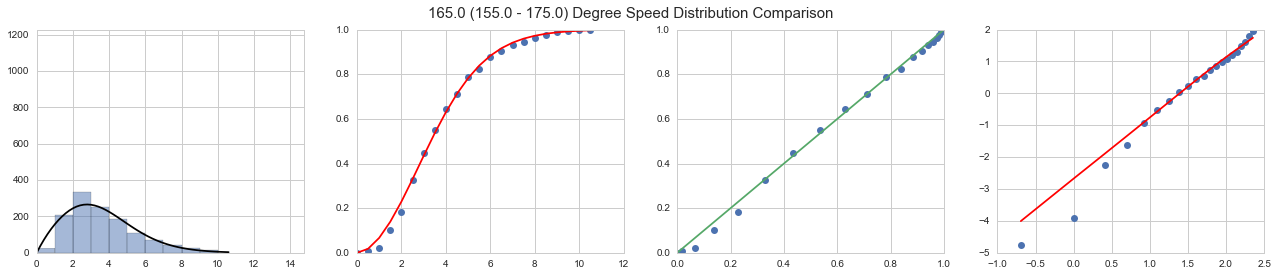

0.0475630982493 2.0 0.229309754425


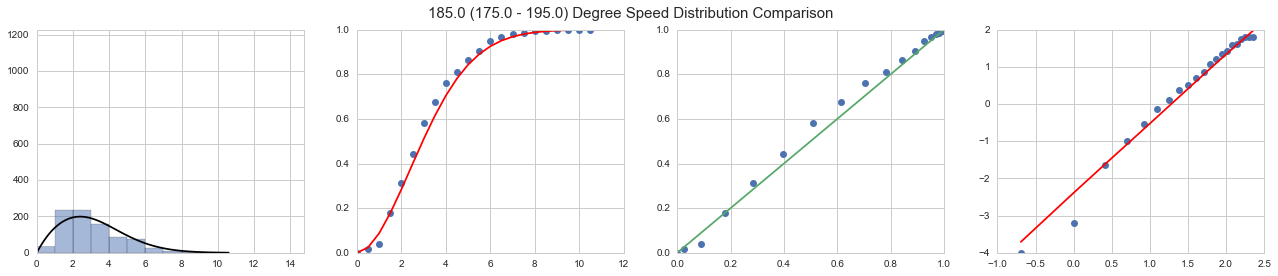

0.0728042005306 3.0 0.509387580291


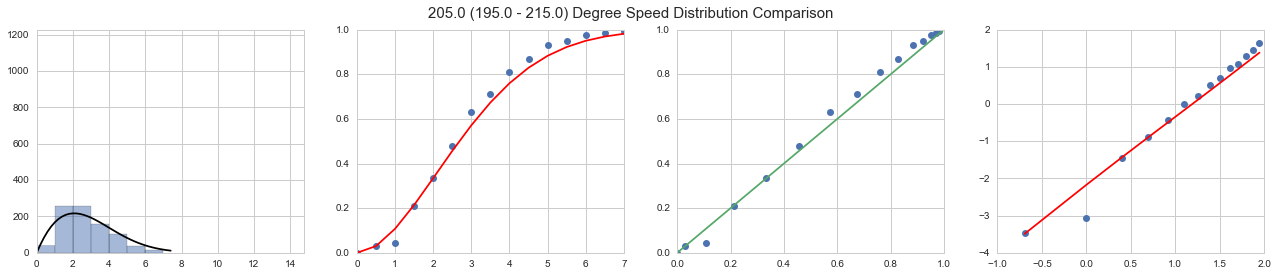

0.0624394495673 1.0 0.10763718968


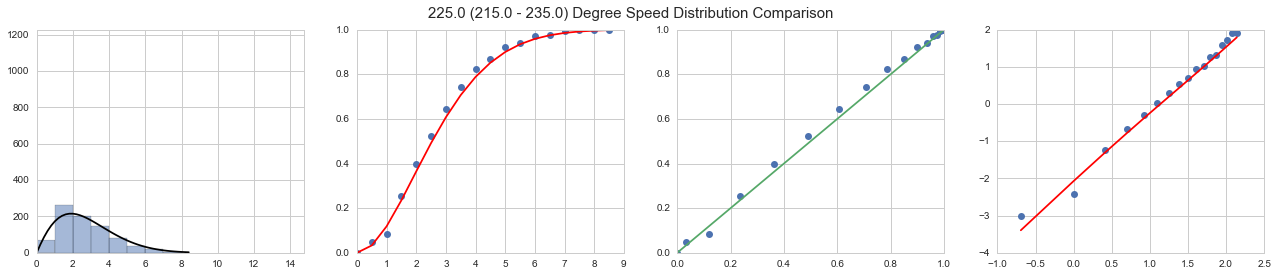

0.0351380631122 2.0 0.364620390994


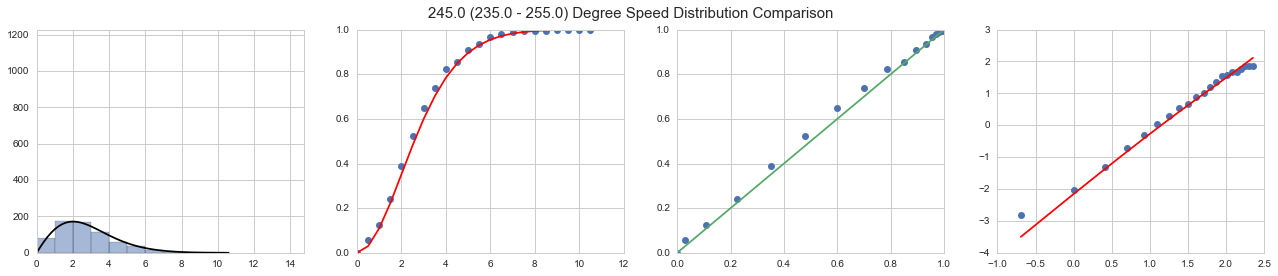

0.0491719624883 3.0 0.599682999344


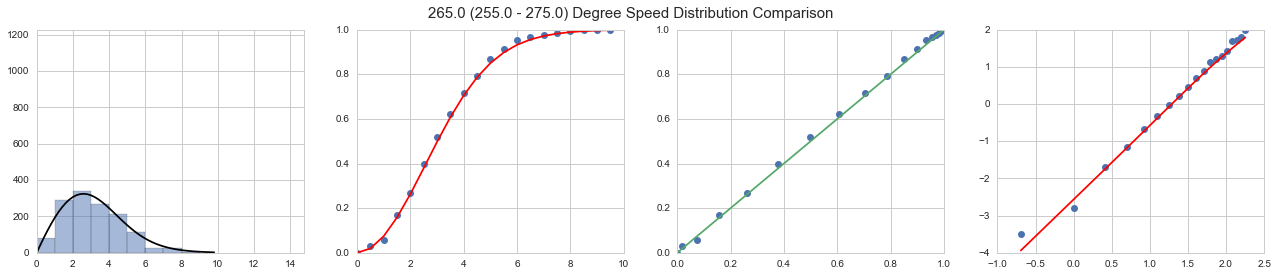

0.0215238959057 6.0 0.931794849536


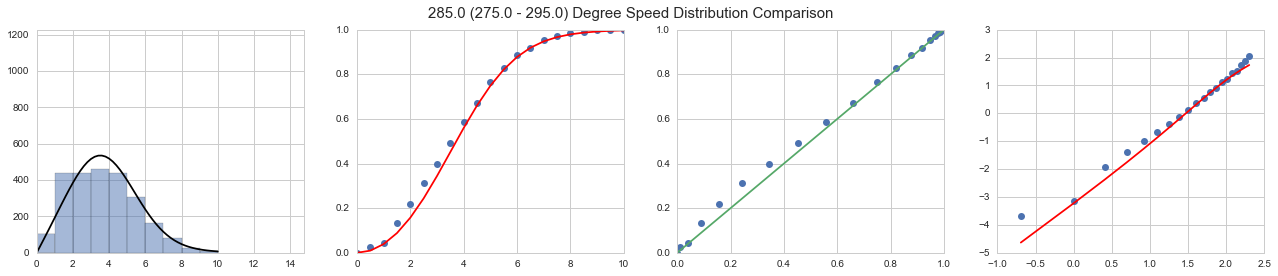

0.0668788720402 2.5 0.243997751336


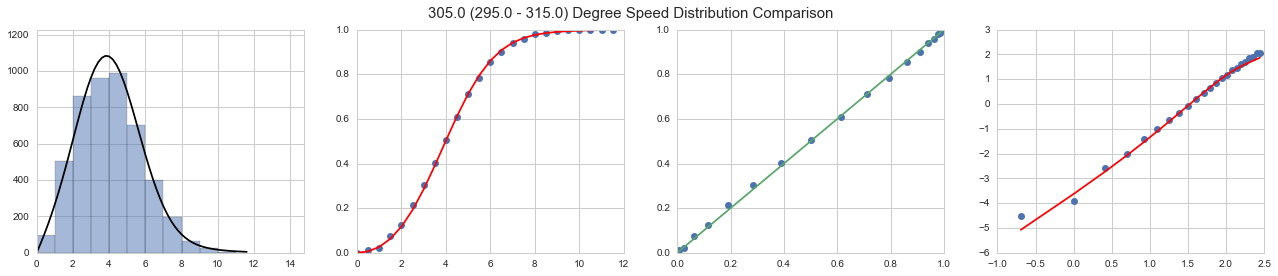

0.0235397792247 2.5 0.19175531637


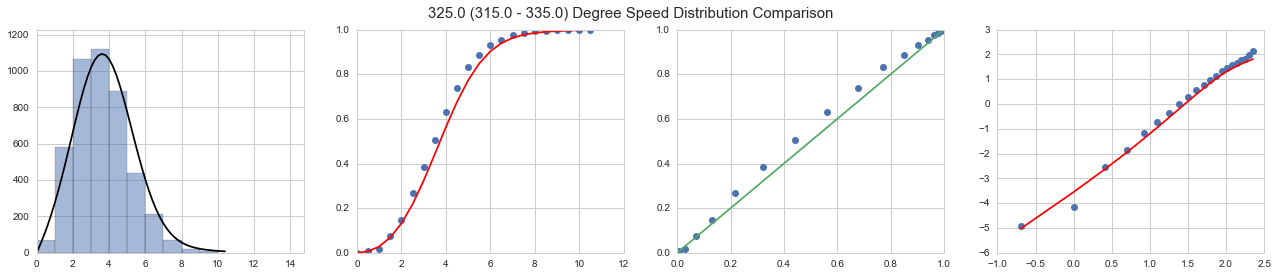

0.0698233324148 4.0 0.563175552758


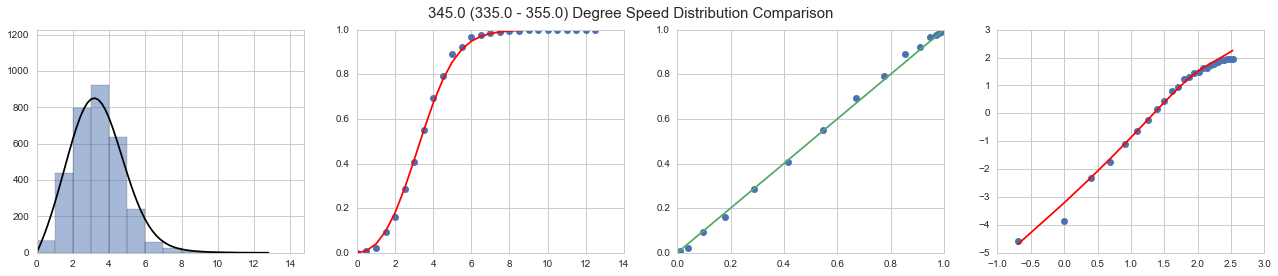

0.0353924622657 5.0 0.855222826734


In [57]:
if cn_database:
    max_diff_array = model_data_comparison(df, SECTOR_LENGTH, 22.5)
else: 
    max_diff_array = model_data_comparison(df, SECTOR_LENGTH, 20)

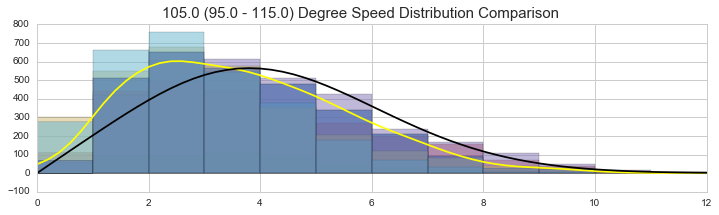

In [58]:
max_diff_element = max(max_diff_array, key=lambda x: x[1])
angle =  max_diff_angle = max_diff_element[0]
incre = 20

# Select data from observation
angle_radian, incre_radian = radians(angle), radians(incre)  
start_angle, end_angle = angle-incre/2, angle+incre/2
sub_df, max_speed = select_df_by_angle(df, start_angle, end_angle)

x_vals = arange(0, max_speed, 0.2)

# 1. Observation

sub_df['speed'].hist(bins=arange(0, max_speed), alpha=0.5,figsize=(12, 3))

# 2. 1d KDE 
sample = array(sub_df.speed).reshape(-1, 1)
sub_kde = neighbors.KernelDensity(bandwidth=0.5).fit(sample) 
y_vals = [exp(sub_kde.score_samples(x_val))*len(sample) 
          for x_val in x_vals]
plt.plot(x_vals, y_vals,'-', color='yellow')

# 3. GMM
y_vals_ =[integrate.nquad(f, [[x_val-0.1, x_val+0.1],[angle_radian-incre_radian/2, angle_radian+incre_radian/2]]) 
          for x_val in x_vals]
direction_prob = integrate.nquad(f, [[0, inf],[angle_radian-incre_radian/2, angle_radian+incre_radian/2]])
y_vals = array(zip(*y_vals_)[0])/direction_prob[0] * len(sub_df.speed)/0.2
plt.plot(x_vals, y_vals,'-', color='black')

for start_time in xrange(19850000, 20150000, 50000):
    end_time = start_time + 50000 
    df_other_years = df_all_years.query('(date >= @start_time) & (date < @end_time)')
    df_other_years_at_angle, _ = select_df_by_angle(df_other_years, start_angle, end_angle)
    if len(df_other_years) > 0 :
        df_other_years_at_angle['speed'].hist(bins=arange(0, max_speed), alpha=0.5,figsize=(12, 3))

plt.suptitle('%s (%s - %s) Degree Speed Distribution Comparison' % (angle, start_angle, end_angle), 
             fontsize = 15)
plt.show()

## Bootstrap, to see the variance of each sector

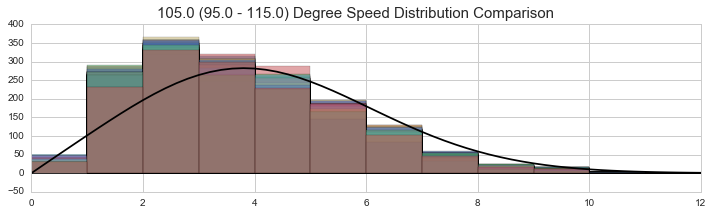

In [59]:
FRACTION = 0.5 

x_vals = arange(0, max_speed, 0.2)
y_vals_ =[integrate.nquad(f, [[x_val-0.1, x_val+0.1],[angle_radian-incre_radian/2, angle_radian+incre_radian/2]]) 
          for x_val in x_vals]
direction_prob = integrate.nquad(f, [[0, inf],[angle_radian-incre_radian/2, angle_radian+incre_radian/2]])
y_vals = array(zip(*y_vals_)[0])/direction_prob[0] * len(sub_df.speed)/0.2 * FRACTION
plt.plot(x_vals, y_vals,'-', color='black')

bins = arange(0, max_speed, 1)
for i in xrange(1,100):
    sub_df_resampled = sub_df.sample(frac=FRACTION, replace=True)
    sub_df_resampled['speed'].hist(bins=bins, alpha=0.5,figsize=(12, 3))

plt.suptitle('%s (%s - %s) Degree Speed Distribution Comparison' % (angle, start_angle, end_angle), 
             fontsize = 15)

0.146172387713 3.5 0.383357813629


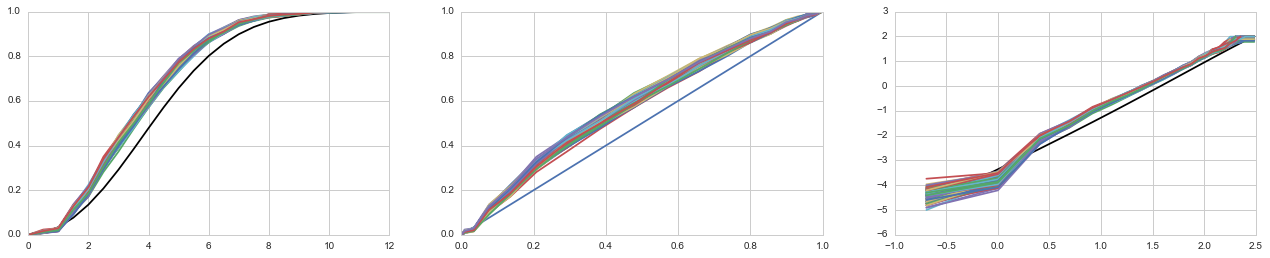

In [60]:
fig = plt.figure(figsize=(22,4))

x = arange(0, max_speed, 0.5)
y_ =[integrate.nquad(f, [[0, x_val],[angle_radian-incre_radian/2, angle_radian+incre_radian/2]]) for x_val in x]
direction_prob = integrate.nquad(f, [[0, inf],[angle_radian-incre_radian/2, angle_radian+incre_radian/2]])
y_gmm = array(zip(*y_)[0])/direction_prob[0]

ax1 = fig.add_subplot(1,3,1) 
plt.plot(x, y_gmm,'-', color = 'black')

ax2 = fig.add_subplot(1,3,2) 
p_line = linspace(0, 1)
plt.plot(p_line, p_line,'-')

ax3 = fig.add_subplot(1,3,3) 
plt.plot(log(x), log(-log(1-y_gmm)),'-', color = 'black')

for i in xrange(1,100):
    sub_df_resampled = sub_df.sample(frac=FRACTION, replace=True)
    
    sample = sub_df_resampled.speed
    ecdf = sm.distributions.ECDF(sample)
    y_cdf = ecdf(x)

    ax1 = fig.add_subplot(1,3,1) 
    plt.plot(x, y_cdf,'-')

    ax2 = fig.add_subplot(1,3,2) 
    plt.plot(y_gmm, y_cdf, '-')

    ax3 = fig.add_subplot(1,3,3) 
    plt.plot(log(x), log(-log(1-y_cdf)),'-')
    
diff = abs(y_cdf - y_gmm)
print diff.max(), x[diff.argmax()], y_gmm[diff.argmax()]

# Cross Validation, to check the number of ellipse to be fitted

In [61]:
from sklearn.cross_validation import train_test_split, KFold
    
def fit_gmm(df, number_of_gaussian = 3, fit_method = 'square_error', print_result = False):
    # 1. Create Input, speed_set
    sample = sub_speed_set = array(zip(df.x, df.y))
    points = FITTING_RANGE
    
    # 2. KDE + EM fitting
    kde = neighbors.KernelDensity(bandwidth=bandwidth).fit(sample) 
    kde_result = exp(kde.score_samples(points))

    clf = mixture.GMM(n_components=number_of_gaussian, covariance_type='full')
    clf.fit(sample)
    gmm_em_result = read_gmm_em_result(clf, print_result)
        
    # 3. GMM fitting
    x0 = gmm_em_result
    bonds = [(0., 0.99),(-30, 30),(-30, 30),(0., 30),(0., 30),(-0.99, 0.99)]*int(len(x0)/6)
    cons = [{'type': 'eq', 'fun': lambda x: sum(x[::6]) - 1},]
 
    result = sp.optimize.minimize(
        lambda x0: GMM_fit_score(x0, kde_result, method=fit_method),
        x0,
        bounds = bonds,
        constraints = cons,
        tol = 0.000000000001,
        options = {"maxiter": 500})  
    
    # 4. Returns
    gmm = group_gmm_param_from_gmm_param_array(result.x)       
    mixed_model_pdf = generate_gmm_pdf_from_grouped_gmm_param(gmm)
    gmm_pdf_result = mixed_model_pdf(points)
    
    return {
        'gmm' : gmm,
        'kde_result': kde_result,
        'gmm_pdf_result': gmm_pdf_result,
        'number_of_iteration': result.nit}

In [62]:
## 5-fold cross validation
CV_result_all =[]
number_of_fold = 4
print 'Number of train/test dataset', len(df)*(number_of_fold-1)/number_of_fold, len(df)/number_of_fold

for number_of_gaussian in xrange(1,6):
    print '  '
    print 'Number of gaussian', number_of_gaussian
    
    kf = KFold(len(df), n_folds=number_of_fold, shuffle=True) # each number of gaussian, fit 4 times

    CV_result = []
    for train_index, test_index in kf:
        sub_df = df.iloc[train_index]
        sub_df_test = df.iloc[test_index]

        # 1. Train
        result = fit_gmm(sub_df, number_of_gaussian, fit_method = FIT_METHOD)
        gmm_pdf_result_train = result['gmm_pdf_result']

        # 2. Validate
        # GMM from Train - KDE from Test
        sample = array(zip(sub_df_test.x, sub_df_test.y))
        kde_test = neighbors.KernelDensity(bandwidth=bandwidth).fit(sample) 
        kde_result_test = exp(kde_test.score_samples(points))

        gof_train = goodness_of_fit_summary(gmm_pdf_result_train, 
                                            kde_result, 
                                            count = len(sub_df))
        gof_test =  goodness_of_fit_summary(gmm_pdf_result_train, 
                                            kde_result_test, 
                                            count = len(sub_df_test))
        
        display(pd.DataFrame([gof_train, gof_test], index=["gof_train", "gof_test"]))
        
        CV_result.append(gof_test)
        
    CV_result_all.append(CV_result)

Number of train/test dataset 30427.5 10142.5
  
Number of gaussian 1


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,0.126829,0.058318,0.000002,0.052138,0.617261,0.900858
gof_test,0.146788,0.057060,0.000002,0.051701,0.638392,0.895416


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,0.127853,0.058226,0.000002,0.051934,0.614854,0.901630
gof_test,0.156296,0.057648,0.000002,0.054560,0.619751,0.900792


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,0.129684,0.059699,0.000002,0.052200,0.617996,0.900622
gof_test,0.209382,0.067829,0.000002,0.057121,0.658487,0.887505


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,0.128678,0.057084,0.000002,0.051807,0.613348,0.902111
gof_test,0.176084,0.052409,0.000002,0.049522,0.604113,0.904490


  
Number of gaussian 2


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,0.033463,0.015363,5.874479e-07,0.028514,0.337577,0.970347
gof_test,0.057570,0.017057,6.604121e-07,0.030185,0.357768,0.966840


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,0.033296,0.018829,5.935727e-07,0.028662,0.339332,0.970038
gof_test,0.049962,0.022522,5.976017e-07,0.028306,0.340946,0.969484


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,0.033432,0.019539,5.973214e-07,0.028752,0.340402,0.969849
gof_test,0.064647,0.025484,7.712147e-07,0.032938,0.387141,0.960965


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,0.033469,0.017827,6.061804e-07,0.028965,0.342917,0.969402
gof_test,0.044261,0.020446,7.215248e-07,0.031905,0.373442,0.964522


  
Number of gaussian 3


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,0.026898,0.015892,4.969576e-07,0.026226,0.31049,0.974915
gof_test,0.034125,0.016588,4.995824e-07,0.026072,0.31141,0.974654


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,0.027010,0.018520,5.036930e-07,0.026403,0.312587,0.974575
gof_test,0.047249,0.025882,6.099046e-07,0.027912,0.344011,0.969378


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,0.027241,0.013816,5.023639e-07,0.026368,0.312174,0.974642
gof_test,0.060200,0.022155,6.174379e-07,0.031641,0.346409,0.968652


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,0.026910,0.015787,4.887304e-07,0.026008,0.307909,0.975330
gof_test,0.039691,0.019214,6.367913e-07,0.028917,0.350984,0.968563


  
Number of gaussian 4


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,0.023707,0.014606,4.038199e-07,0.023641,0.279886,0.979616
gof_test,0.057885,0.015176,4.840419e-07,0.024941,0.306629,0.976208


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,0.023361,0.011440,4.130161e-07,0.023909,0.283055,0.979152
gof_test,0.035289,0.016066,4.521136e-07,0.026373,0.295709,0.976538


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,0.023320,0.015603,4.270463e-07,0.024311,0.287823,0.978444
gof_test,0.042536,0.023806,6.647545e-07,0.029339,0.359041,0.967177


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,0.023393,0.014634,4.172320e-07,0.024030,0.284496,0.978939
gof_test,0.037560,0.015780,4.912743e-07,0.026611,0.309021,0.975093


  
Number of gaussian 5


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,0.020977,0.009733,3.482896e-07,0.021955,0.259931,0.982419
gof_test,0.034250,0.010363,3.202738e-07,0.021427,0.249202,0.983658


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,0.020599,0.010287,3.124943e-07,0.020797,0.246212,0.984226
gof_test,0.034956,0.012392,3.884619e-07,0.023515,0.274730,0.980166


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,0.021570,0.014703,3.765281e-07,0.022828,0.270263,0.980994
gof_test,0.047758,0.020630,5.158800e-07,0.026517,0.316229,0.974572


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,0.017680,0.008388,2.402868e-07,0.018236,0.215900,0.987871
gof_test,0.030877,0.009912,3.410070e-07,0.021222,0.257149,0.983024


In [63]:
for idx, gof_group in enumerate(CV_result_all):
    print 'number of gaussian', idx+1
    display(pd.DataFrame(gof_group))

number of gaussian 1


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,0.146788,0.057060,0.000002,0.051701,0.638392,0.895416
1,0.156296,0.057648,0.000002,0.054560,0.619751,0.900792
2,0.209382,0.067829,0.000002,0.057121,0.658487,0.887505
3,0.176084,0.052409,0.000002,0.049522,0.604113,0.904490


number of gaussian 2


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,0.057570,0.017057,6.604121e-07,0.030185,0.357768,0.966840
1,0.049962,0.022522,5.976017e-07,0.028306,0.340946,0.969484
2,0.064647,0.025484,7.712147e-07,0.032938,0.387141,0.960965
3,0.044261,0.020446,7.215248e-07,0.031905,0.373442,0.964522


number of gaussian 3


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,0.034125,0.016588,4.995824e-07,0.026072,0.311410,0.974654
1,0.047249,0.025882,6.099046e-07,0.027912,0.344011,0.969378
2,0.060200,0.022155,6.174379e-07,0.031641,0.346409,0.968652
3,0.039691,0.019214,6.367913e-07,0.028917,0.350984,0.968563


number of gaussian 4


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,0.057885,0.015176,4.840419e-07,0.024941,0.306629,0.976208
1,0.035289,0.016066,4.521136e-07,0.026373,0.295709,0.976538
2,0.042536,0.023806,6.647545e-07,0.029339,0.359041,0.967177
3,0.037560,0.015780,4.912743e-07,0.026611,0.309021,0.975093


number of gaussian 5


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,0.034250,0.010363,3.202738e-07,0.021427,0.249202,0.983658
1,0.034956,0.012392,3.884619e-07,0.023515,0.274730,0.980166
2,0.047758,0.020630,5.158800e-07,0.026517,0.316229,0.974572
3,0.030877,0.009912,3.410070e-07,0.021222,0.257149,0.983024


In [64]:
mean_gof_all = []
for idx, gof_group in enumerate(CV_result_all):
    mean_gof = np.mean(pd.DataFrame(gof_group))
    mean_gof_all.append(mean_gof)
mean_gof_all = pd.DataFrame(mean_gof_all)
mean_gof_all

,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,0.172137,0.058737,2.049234e-06,0.053226,0.630186,0.897051
1,0.054110,0.021377,6.876883e-07,0.030833,0.364824,0.965453
2,0.045316,0.020960,5.909291e-07,0.028635,0.338204,0.970312
3,0.043318,0.017707,5.230461e-07,0.026816,0.317600,0.973754
4,0.036960,0.013324,3.914057e-07,0.023170,0.274327,0.980355


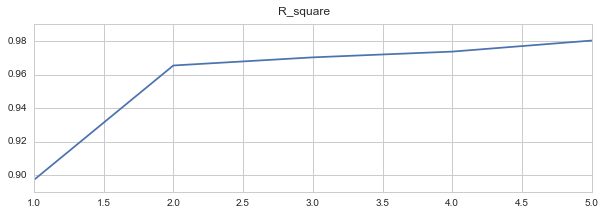

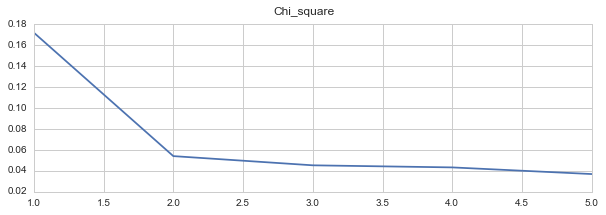

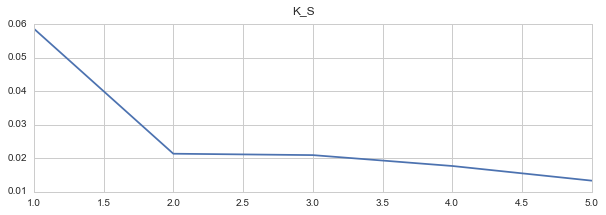

In [65]:
x = arange(1,6)
for column in ['R_square','Chi_square', 'K_S']:
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 3)
    plt.plot(x, mean_gof_all[column],'-')
    plt.suptitle(column)
    plt.show()